How many are Retweets?

Class balance
- subject
- time
- places
- users

Classification over time - clustering
Do more active ids have more followers?

- CLASS BALANCE
- CLASS BALANCE LULA x BOLSONARO

- CLASS BALANCE FOLLOWERS - TWEET COUNT - VERIFIED
- most commum emojis
- time


In [1]:
import numpy as np
import pandas as pd
import emoji
import nltk
from nltk.probability import FreqDist
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from gensim.models import Word2Vec, KeyedVectors
import matplotlib.lines as mlines
from sklearn.metrics import silhouette_score

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)
sns.set_theme()



### Helper Functions

In [2]:

def get_word_dist(tokens_list):
    flat_list = [item for sublist in tokens_list for item in sublist]
    fd = FreqDist(flat_list)
    return pd.DataFrame(fd.most_common(40))


def find_ngrams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])


def plot_cadidate_wc(candidate, ngram = None):   
    
    color_dict = {
        'lula':'orange',
        'bolsonaro':'blue'
    }


    df_ = df[df.subject == candidate].copy()
    if not ngram:
        df_fd_all = get_word_dist(df_.tokens.tolist())
        df_fd_pos = get_word_dist(df_[df_.target == 1].tokens.tolist())
        df_fd_neg = get_word_dist(df_[df_.target == 0].tokens.tolist())
        ngram = 'unigram'
    else:
        df_fd_all = get_word_dist([list(find_ngrams(tweet_tk, ngram)) for tweet_tk in df_.tokens.tolist()])
        df_fd_all[0] = df_fd_all[0].astype(str)
        
        df_fd_pos = get_word_dist([list(find_ngrams(tweet_tk, ngram)) for tweet_tk in df_[df_.target == 1].tokens.tolist()])
        df_fd_pos[0] = df_fd_pos[0].astype(str)

        df_fd_neg = get_word_dist([list(find_ngrams(tweet_tk, ngram)) for tweet_tk in df_[df_.target == 0].tokens.tolist()])
        df_fd_neg[0] = df_fd_neg[0].astype(str)


    fig, ax = plt.subplots(3,1, figsize = (18,30), constrained_layout=True)
    fig.suptitle(f'\n\n\n\n{candidate.upper()} - WORD DISTRIBUTION - ngram {ngram}', fontsize=18)

    sns.barplot(x=df_fd_all[0], y=df_fd_all[1], ax=ax[0], color=color_dict.get(candidate,'black'), alpha = 0.6)
    sns.barplot(x=df_fd_pos[0], y=df_fd_pos[1], ax=ax[1], color='green', alpha = 0.6)
    sns.barplot(x=df_fd_neg[0], y=df_fd_neg[1], ax=ax[2], color='red', alpha = 0.6)

    for i, df_fd, title in zip(range(3),[df_fd_all, df_fd_pos, df_fd_neg], ['POSITIVE AND NEGATIVE TWEETS', 'POSITIVE TWEETS', 'NEGATIVE TWEETS']):
        ax[i].set_xticklabels(df_fd[0], rotation=45, fontsize=12)
        ax[i].set_title('\n\n\n'+title, fontsize=16)
        ax[i].set_xlabel('\n')
        ax[i].set_ylabel('WORD COUNT')

    plt.show()


def print_corpus_stats(corpus):
    flat_corpus = [item for sublist in corpus for item in sublist]
    nwords = len(flat_corpus)
    avg_word_length = np.mean([len(w) for w in flat_corpus])
    print('Number of docs:', len(corpus))
    print('Words count:', nwords)
    print('Average word length:', avg_word_length)



def eval_kmeans_clusters(nks, vec):
    nks += 1
    sse = []
    silhouette = []
    for k in range(2, nks):
        means = KMeans(n_clusters=k)
        means.fit(vec)
        sse.append(means.inertia_)
        silhouette.append(silhouette_score(vec, means.labels_))


    print(f'Best Silhouette score: {max(silhouette)}, Number of clusters: {np.argmax(silhouette)+2}')

    fig,ax = plt.subplots(2, 1, figsize=(18,20))
    ax[0].plot(range(2, nks), sse)
    ax[0].set_xticks(range(2, nks))
    ax[0].set_xlabel("Number of Clusters")
    ax[0].set_ylabel("SSE")
    ax[0].set_title("SSE", fontsize=16)

    ax[1].plot(range(2, nks), silhouette)
    ax[1].set_xticks(range(2, nks))
    ax[1].set_xlabel("Number of Clusters".upper())
    ax[1].set_ylabel("Silhouette Coefficient".upper())
    ax[1].set_title("Silhouette Coefficient".upper(), fontsize=16)
    plt.show()






def get_top_keywords(data, clusters, labels, n_terms):
    '''
    Return a dict: {cluster_number : top_words}
    '''
    df_ = pd.DataFrame(data.todense()).groupby(clusters).mean()
    cluster_topwords = {}
    for i,r in df_.iterrows():
        cluster_topwords[i] = ' - '.join([labels[t] for t in np.argsort(r)[-n_terms:]])
    return cluster_topwords


def get_top_keywords_w2v(n_clusters):
    cluster_topwords = {}
    for i in range(n_clusters):
        words = model.wv.most_similar(positive=[means.cluster_centers_[i]], topn=20)
        cluster_topwords[i] = [w[0] for w in words]
    return cluster_topwords



def kmeans_summary(labels, cluster_topwords):
    '''
    Returns DataFrame with qty, positive/negative count and top key words
    '''
    top_words = pd.Series([v for k,v in cluster_topwords.items()]).rename('top_words')
    df_ = pd.concat([pd.Series(cls_target).rename('target'), pd.Series(labels).rename('cluster')], axis=1).groupby(['cluster']).agg({'target':['count','sum']})['target'].reset_index().rename(columns={'count':'number_of_docs', 'sum':'positive'})
    df_['negative'] = df_.number_of_docs - df_.positive
    df_ = pd.concat([df_, top_words], axis=1)
    return df_



            


def plot_tsne_pca_full(vec, labels, cls_target):
    '''
    Visualize kmeans clusters stratifies by target variable.
    '''

    # Filtering POS nad NEG
    vec_pos = vec.todense()[np.array(cls_target)>0]
    vec_neg = vec.todense()[np.array(cls_target)<1]

    label_pos = np.array(labels)[np.array(cls_target)>0]
    label_neg = np.array(labels)[np.array(cls_target)<1]


    # # PCA and TSNE labeled data
    pca_pos = PCA(n_components=2).fit_transform(vec_pos)
    pca_neg = PCA(n_components=2).fit_transform(vec_neg)

    tsne_pos = TSNE().fit_transform(PCA(n_components=50).fit_transform(vec_pos))
    tsne_neg = TSNE().fit_transform(PCA(n_components=50).fit_transform(vec_neg))


    # Build color dict
    colors_dict = {i: cm.hsv((i)/len(set(labels))) for i in set(labels)}

    # Assign colors
    label_colors_pos = [colors_dict[i] for i in label_pos]
    label_colors_neg = [colors_dict[i] for i in label_neg]

    # Setup legend
    pos_legend_lb = mlines.Line2D([], [], color='black', marker='*', markersize=10, label='Positive Tweets', linestyle="")
    neg_legend_lb = mlines.Line2D([], [], color='black', marker='s', markersize=7, label='Negative Tweets', linestyle="")

    handles = [ mpatches.Patch(color=colors_dict[cluster], label=f'Cluster number {cluster}') for cluster in colors_dict]
    handles.append(pos_legend_lb)
    handles.append(neg_legend_lb)

    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(22, 10))

    ax[0].scatter(pca_pos[:, 0], pca_pos[:, 1], c=label_colors_pos, alpha=0.5, marker="*", s=100)
    ax[0].scatter(pca_neg[:, 0], pca_neg[:, 1], c=label_colors_neg, alpha=0.5, marker="s")
    ax[0].set_title('PCA PLOT')

    ax[1].scatter(tsne_pos[:, 0], tsne_pos[:, 1], c=label_colors_pos, alpha=0.5, marker="*", s=100)
    ax[1].scatter(tsne_neg[:, 0], tsne_neg[:, 1], c=label_colors_neg, alpha=0.5, marker="s")
    ax[1].set_title('TSNE PLOT')

    plt.legend(handles=handles)



def check_training(word):
    '''
    Compare original word2vec model with the finedtuned one.
    '''
    print('Pre trained model:')
    try:
        for i in model_original.wv.most_similar(word):
            print('\t',i)
    except:
        print(f'\t Word {word} was not found in the vocabulary.')

    print('\n\nFine tunned model:')
    try:
        for i in model.wv.most_similar(word):
            print('\t',i)
    except:
        print(f'\t Word {word} was not found in the vocabulary.')




def vectorize(corpus, model):
    """Generate vectors for list of documents.

    Args:
        corpus: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tweet in corpus:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tweet:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features




def plot_tsne_pca_full_w2v(vec, labels, cls_target):
    '''
    Visualize kmeans clusters stratifies by target variable.
    '''

    # Filtering POS nad NEG
    vec_pos = np.array(vec)[np.array(cls_target)>0]
    vec_neg = np.array(vec)[np.array(cls_target)<1]

    label_pos = np.array(labels)[np.array(cls_target)>0]
    label_neg = np.array(labels)[np.array(cls_target)<1]


    # # PCA and TSNE labeled data
    pca_pos = PCA(n_components=2).fit_transform(vec_pos)
    pca_neg = PCA(n_components=2).fit_transform(vec_neg)

    tsne_pos = TSNE().fit_transform(PCA(n_components=50).fit_transform(vec_pos))
    tsne_neg = TSNE().fit_transform(PCA(n_components=50).fit_transform(vec_neg))


    # Build color dict
    colors_dict = {i: cm.hsv((i)/len(set(labels))) for i in set(labels)}

    # Assign colors
    label_colors_pos = [colors_dict[i] for i in label_pos]
    label_colors_neg = [colors_dict[i] for i in label_neg]

    # Setup legend
    pos_legend_lb = mlines.Line2D([], [], color='black', marker='*', markersize=10, label='Positive Tweets', linestyle="")
    neg_legend_lb = mlines.Line2D([], [], color='black', marker='s', markersize=7, label='Negative Tweets', linestyle="")

    handles = [ mpatches.Patch(color=colors_dict[cluster], label=f'Cluster number {cluster}') for cluster in colors_dict]
    handles.append(pos_legend_lb)
    handles.append(neg_legend_lb)

    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(22, 10))

    ax[0].scatter(pca_pos[:, 0], pca_pos[:, 1], c=label_colors_pos, alpha=0.5, marker="*", s=100)
    ax[0].scatter(pca_neg[:, 0], pca_neg[:, 1], c=label_colors_neg, alpha=0.5, marker="s")
    ax[0].set_title('PCA PLOT')

    ax[1].scatter(tsne_pos[:, 0], tsne_pos[:, 1], c=label_colors_pos, alpha=0.5, marker="*", s=100)
    ax[1].scatter(tsne_neg[:, 0], tsne_neg[:, 1], c=label_colors_neg, alpha=0.5, marker="s")
    ax[1].set_title('TSNE PLOT')

    plt.legend(handles=handles)



### Setup Dataset

In [11]:
labels = pd.read_parquet('../../data/2-intermediate/labels.parquet')[['id', 'target']]
tweets = pd.read_parquet('../../data/2-intermediate/tweets.parquet').drop_duplicates(subset=['id'])
users = pd.read_parquet('../../data/1-raw/users.parquet')[['id', 'username','name', 'location', 'followers_count', 'following_count', 'listed_count', 'tweet_count', 'verified']]
places = pd.read_parquet('../../data/1-raw/places.parquet')[['id', 'full_name', 'country', 'place_type']]


df = tweets.copy()

df = df.merge(places, left_on='place_id', right_on='id', how='left', suffixes = (None, '_places'))
df = df.merge(users, left_on='author_id', right_on='id', how='left', suffixes = (None, '_users'))
df = df.merge(labels, on='id', how='inner', suffixes = (None, '_labels'))
df = df.drop(columns=['author_id', 'place_id', 'lang', 'is_retweet', 'verified'])
df.created_at = df.created_at.dt.date

df['nwords'] = df.tokens.apply(lambda x: len(x))
df['avg_word_lenght'] = df.tokens.apply(lambda x: np.mean([len(token) for token in x]))
df['question_mark_count'] = df.text.apply(lambda x: len([ i for i in x if i == "?"]))
df['exclamation_mark_count'] = df.text.apply(lambda x: len([ i for i in x if i == "!"]))
df['hastag_count'] = df.text.apply(lambda x: len([ i for i in x if i == "#"]))

print('\ndf shape:',df.shape)
df.head(10)



df shape: (2271, 26)


id  created_at  \
0  1542153389949198339  2022-06-29   
1  1542153354813575173  2022-06-29   
2  1542153308739182592  2022-06-29   
3  1542153305320787972  2022-06-29   
4  1542153283795619840  2022-06-29   
5  1542153223573757952  2022-06-29   
6  1542153221501763584  2022-06-29   
7  1542153204301008898  2022-06-29   
8  1542153173233803264  2022-06-29   
9  1542153127914250241  2022-06-29   

                                                                                                                                                                                                                                                                                                                   text  \
0                                                                                                                                                                                  Que vergonha, só poderia ser um escolhido do Bolsonaro.#ApuraçãoAssedioPG
#ForaPedroGuimarães
#AfastamentoJá https://t.co/1CAyiI81Lx   
1                                                                                                                                             A proliferação de falsos profetas, chantagistas, achacadores e assaltantes dos cofres públicos no governo Bolsonaro é enorme safadeza e tem que ser investigada a fundo 🤔   
2  @UOLNoticias @madeleinelacsko Vcs da UOLixo são mto RIDÍCULOS. Sem noção, militantes políticos se passando por jornalistas. Que isso??? E daí que Piquet é bolsonarista. Se ele fosse lulista, puxasse saco do chefe de vcs a reportagem seria diferente? Piquet é Piquet com ou sem Bolsonaro. Chega seus RIDÍCULOS   
3                                                                                                                                                                    Matéria bem ao estilo imprensa marron. 
Bolsonaro e Alexandre de Moraes conversam a portas fechadas na casa de Arthur Lira https://t.co/lqdQC3dgLG   
4                                                                                                                                                                                                                        Bolsonaro sanciona lei que devolve PIS/Cofins cobrado na conta de luz
 https://t.co/44advJw5U6   
5                              Nesta semana, Deltan Dallagnol (que se diz contra a corrupção), afirmou que votará em Bolsonaro, denunciado e investigado por corrupção, em um eventual 2º turno contra Lula, absolvido após suspensão do juiz amigo do Deltan e ex-funcionário de Bolsonaro. Nunca foi sobre corrupção.   
6                                                                                                                Preparem-se para quando o presidente da #CEF amigão do #Bolsonaro acusado de assédio sexual renunciar.

A tag #quemmatoucelsodaniel deverá novamente ser levantada pra criar uma cortininha de fumaça.   
7                                                                                                                                                                                                                                          o empoderamento feminino no gov bolsonaro vindo 🤩kkk https://t.co/5iGJGQ8V2X   
8                                                                                                                                  Quando perceberem (os gados), o Brasil já desceu a ladeira...

Estado de Minas: Collor e Bolsonaro: juntos e misturados, tutti buona gente.
https://t.co/x0j1wZqNN5

via @GoogleNews   
9                                                                                                                                                                                                                                                                         @desmentindobozo é nóix DESMENTINDO BOLSONARO   

     subject created_at_date created_at_time emoji  \
0  bolsonaro      2022-06-29        14:29:54  None   
1  bolsonaro      2022-06-2

In [4]:
# df_ = df[['subject','followers_count', 'following_count', 'listed_count', 'tweet_count', 'nwords', 'avg_word_lenght', 'question_mark_count', 'exclamation_mark_count', 'target']]
# df_['subject'] = np.where(df_['subject'] == 'bolsonaro', 1, 0)
# df_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


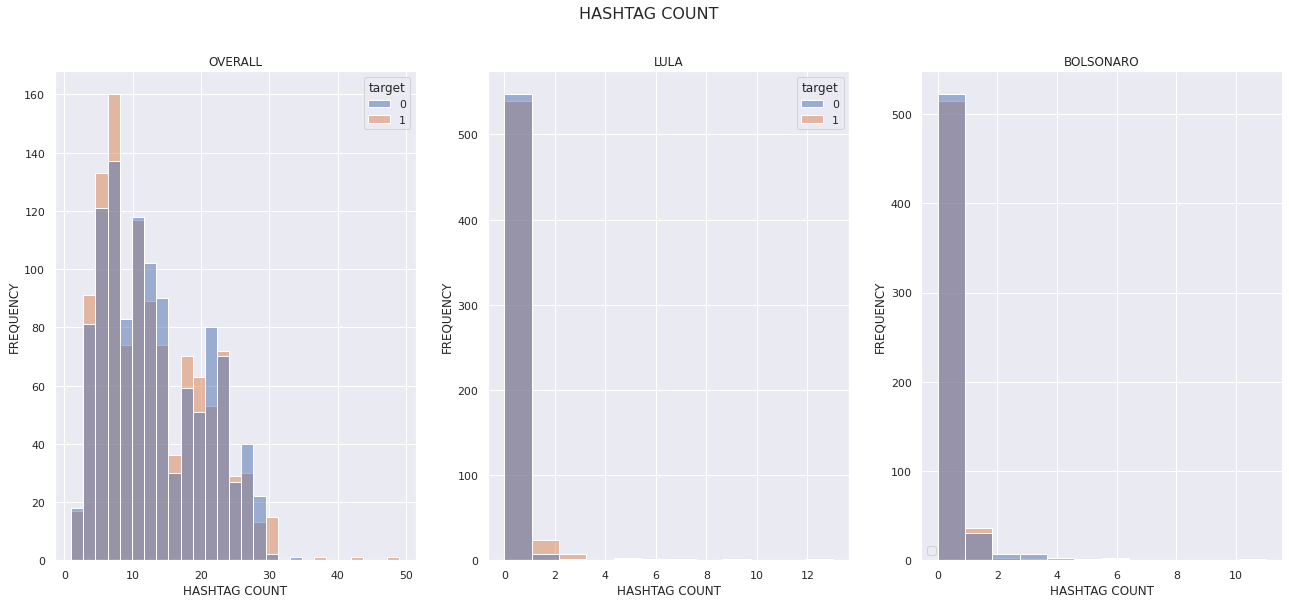

In [12]:
fig, ax = plt.subplots(1,3, figsize = (22,9))
sns.histplot(x=df.nwords,  ax=ax[0], hue=df.target)
sns.histplot(x=df[df.subject == 'lula'].hastag_count,  ax=ax[1], hue=df[df.subject == 'lula'].target)
sns.histplot(x=df[df.subject == 'bolsonaro'].hastag_count,  ax=ax[2], hue=df[df.subject == 'bolsonaro'].target)
ax[0].set_xlabel('HASHTAG COUNT')
ax[0].set_ylabel('FREQUENCY')
ax[0].set_title('OVERALL')
ax[1].set_ylabel('FREQUENCY')
ax[1].set_xlabel('HASHTAG COUNT')
ax[1].set_title('LULA')
ax[2].set_ylabel('FREQUENCY')
ax[2].set_xlabel('HASHTAG COUNT')
ax[2].set_title('BOLSONARO')

fig.suptitle('HASHTAG COUNT', fontsize=16)
plt.legend(loc=3)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


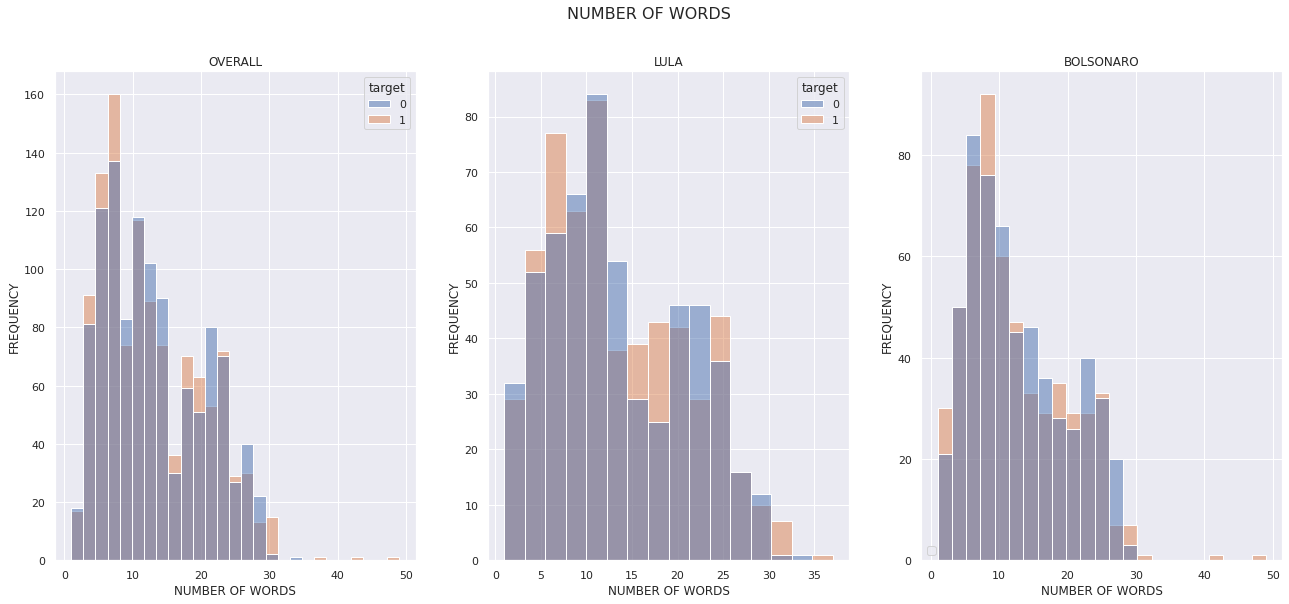

In [5]:
fig, ax = plt.subplots(1,3, figsize = (22,9))
sns.histplot(x=df.nwords,  ax=ax[0], hue=df.target)
sns.histplot(x=df[df.subject == 'lula'].nwords,  ax=ax[1], hue=df[df.subject == 'lula'].target)
sns.histplot(x=df[df.subject == 'bolsonaro'].nwords,  ax=ax[2], hue=df[df.subject == 'bolsonaro'].target)
ax[0].set_xlabel('NUMBER OF WORDS')
ax[0].set_ylabel('FREQUENCY')
ax[0].set_title('OVERALL')
ax[1].set_ylabel('FREQUENCY')
ax[1].set_xlabel('NUMBER OF WORDS')
ax[1].set_title('LULA')
ax[2].set_ylabel('FREQUENCY')
ax[2].set_xlabel('NUMBER OF WORDS')
ax[2].set_title('BOLSONARO')

fig.suptitle('NUMBER OF WORDS', fontsize=16)
plt.legend(loc=3)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


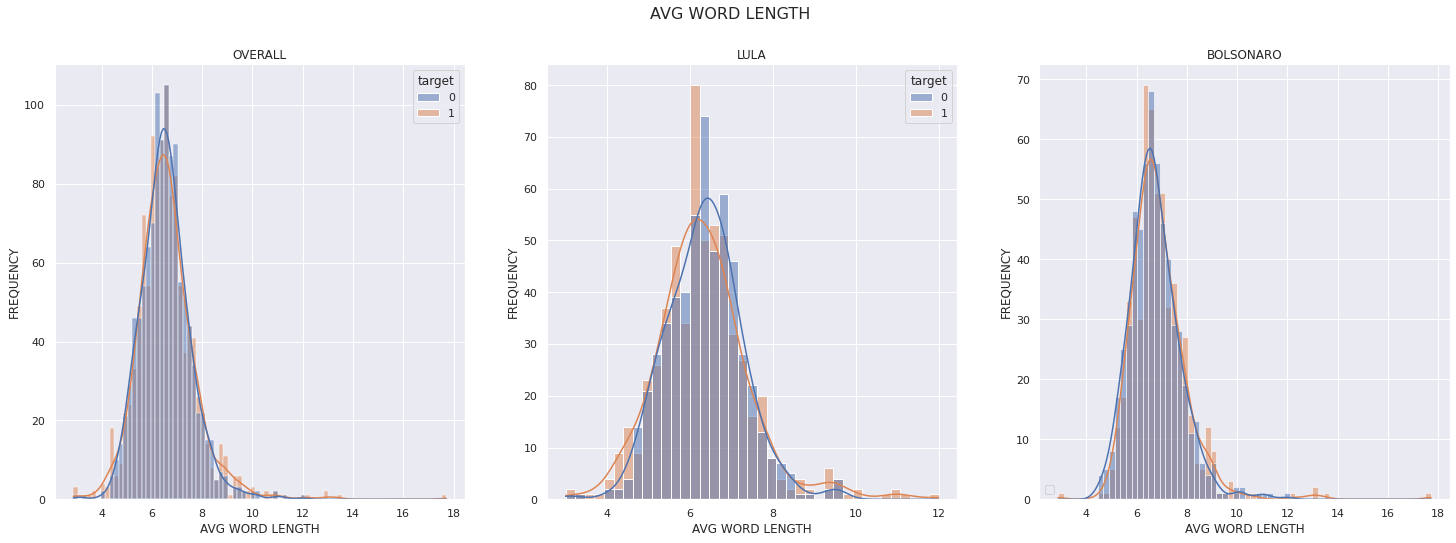

In [6]:
fig, ax = plt.subplots(1,3, figsize = (25,8))
sns.histplot(x=df.avg_word_lenght,  ax=ax[0], hue=df.target, kde=True)
sns.histplot(x=df[df.subject == 'lula'].avg_word_lenght,  ax=ax[1], hue=df[df.subject == 'lula'].target, kde=True)
sns.histplot(x=df[df.subject == 'bolsonaro'].avg_word_lenght,  ax=ax[2], hue=df[df.subject == 'bolsonaro'].target, kde=True)
ax[0].set_xlabel('AVG WORD LENGTH')
ax[0].set_ylabel('FREQUENCY')
ax[0].set_title('OVERALL')
ax[1].set_ylabel('FREQUENCY')
ax[1].set_xlabel('AVG WORD LENGTH')
ax[1].set_title('LULA')
ax[2].set_ylabel('FREQUENCY')
ax[2].set_xlabel('AVG WORD LENGTH')
ax[2].set_title('BOLSONARO')

fig.suptitle('AVG WORD LENGTH', fontsize=16)
plt.legend(loc=3)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


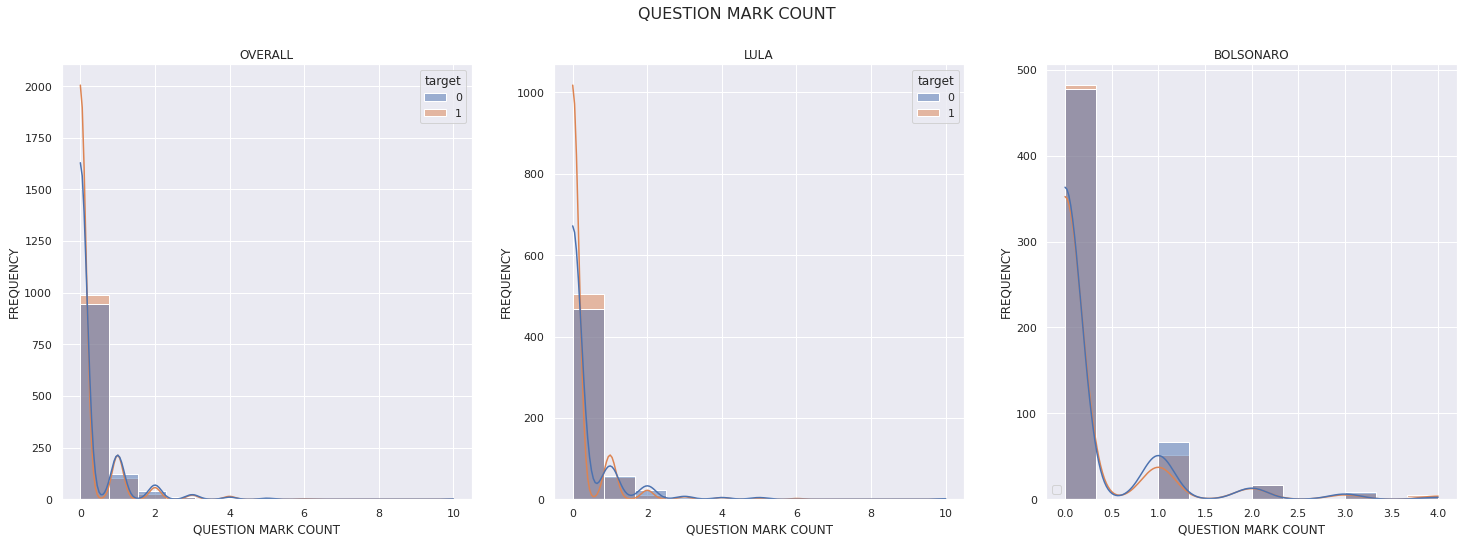

In [7]:
fig, ax = plt.subplots(1,3, figsize = (25,8))
sns.histplot(x=df.question_mark_count,  ax=ax[0], hue=df.target, kde=True)
sns.histplot(x=df[df.subject == 'lula'].question_mark_count,  ax=ax[1], hue=df[df.subject == 'lula'].target, kde=True)
sns.histplot(x=df[df.subject == 'bolsonaro'].question_mark_count,  ax=ax[2], hue=df[df.subject == 'bolsonaro'].target, kde=True)
ax[0].set_xlabel('QUESTION MARK COUNT')
ax[0].set_ylabel('FREQUENCY')
ax[0].set_title('OVERALL')
ax[1].set_ylabel('FREQUENCY')
ax[1].set_xlabel('QUESTION MARK COUNT')
ax[1].set_title('LULA')
ax[2].set_ylabel('FREQUENCY')
ax[2].set_xlabel('QUESTION MARK COUNT')
ax[2].set_title('BOLSONARO')

fig.suptitle('QUESTION MARK COUNT', fontsize=16)
plt.legend(loc=3)
plt.show()

In [8]:
question_mark_count	exclamation_mark_count

SyntaxError: invalid syntax (1926383454.py, line 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


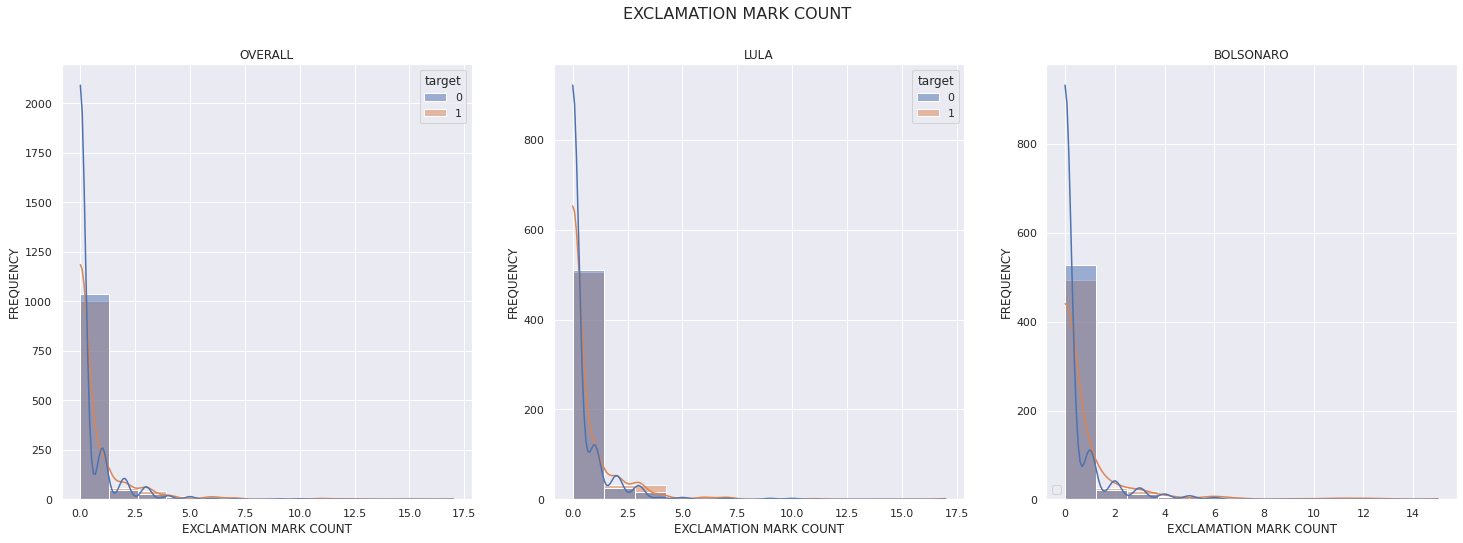

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (25,8))
sns.histplot(x=df.exclamation_mark_count,  ax=ax[0], hue=df.target, kde=True)
sns.histplot(x=df[df.subject == 'lula'].exclamation_mark_count,  ax=ax[1], hue=df[df.subject == 'lula'].target, kde=True)
sns.histplot(x=df[df.subject == 'bolsonaro'].exclamation_mark_count,  ax=ax[2], hue=df[df.subject == 'bolsonaro'].target, kde=True)
ax[0].set_xlabel('EXCLAMATION MARK COUNT')
ax[0].set_ylabel('FREQUENCY')
ax[0].set_title('OVERALL')
ax[1].set_ylabel('FREQUENCY')
ax[1].set_xlabel('EXCLAMATION MARK COUNT')
ax[1].set_title('LULA')
ax[2].set_ylabel('FREQUENCY')
ax[2].set_xlabel('EXCLAMATION MARK COUNT')
ax[2].set_title('BOLSONARO')

fig.suptitle('EXCLAMATION MARK COUNT', fontsize=16)
plt.legend(loc=3)
plt.show()

### Class Balance and Stratification by Candidate

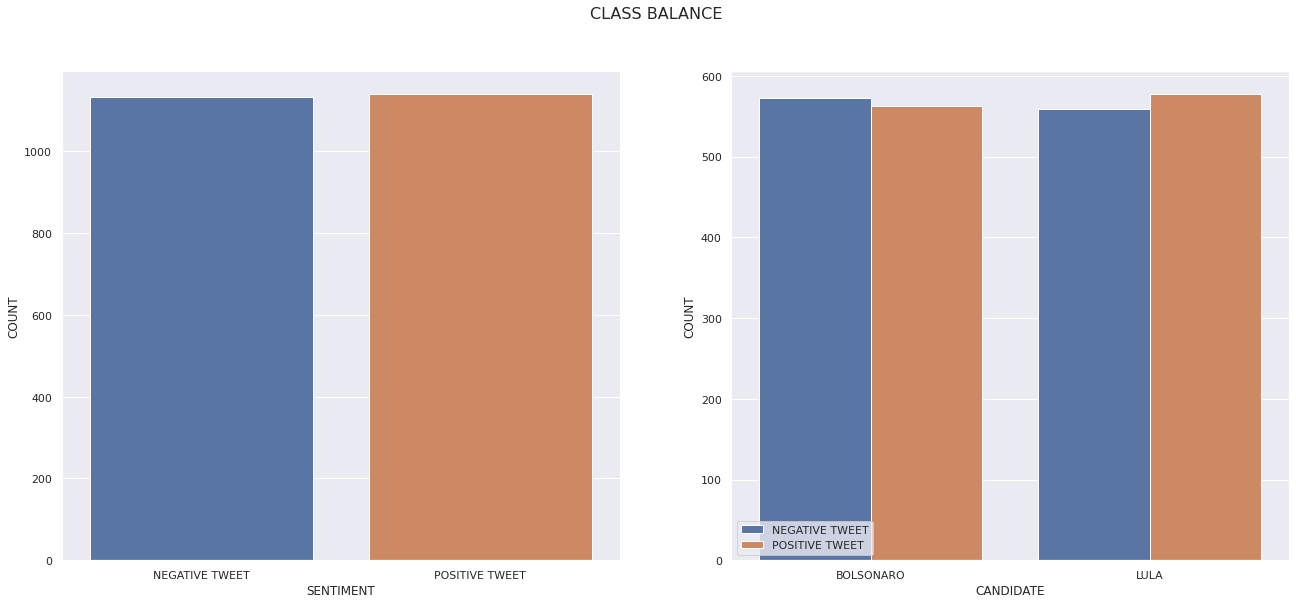

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (22,9))
sns.countplot(x = np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'), ax=ax[0])
sns.countplot(x =df.subject , hue=np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'), ax=ax[1])
ax[0].set_xlabel('SENTIMENT')
ax[0].set_ylabel('COUNT')
ax[1].set_ylabel('COUNT')
ax[1].set_xlabel('CANDIDATE')
ax[1].set_xticks([0,1], ['BOLSONARO', 'LULA'])
fig.suptitle('CLASS BALANCE', fontsize=16)
plt.legend(loc=3)
plt.show()


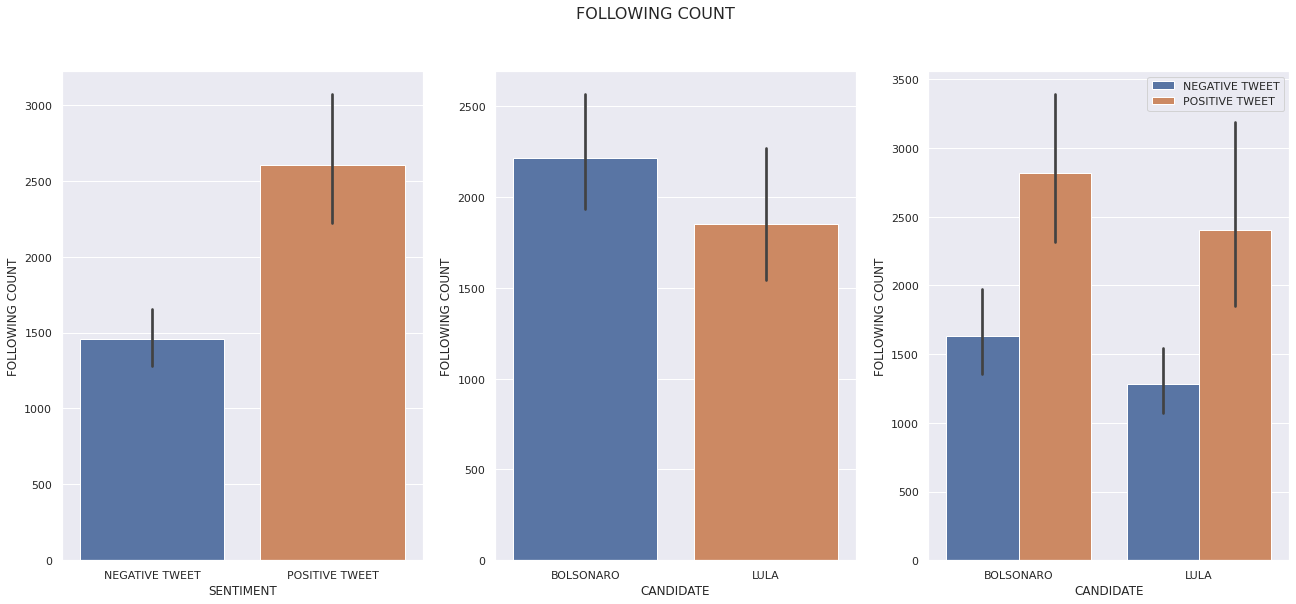

In [ ]:

fig, ax = plt.subplots(1,3, figsize = (22,9))
sns.barplot(x = np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),y = df.following_count,  ax=ax[0])
sns.barplot(x = df.subject,y = df.following_count, ax=ax[1])
# sns.barplot(x = np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),y = df.following_count,  hue= df.subject,ax=ax[2])
sns.barplot(x = df.subject ,y = df.following_count,  hue= np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),ax=ax[2])
ax[0].set_xlabel('SENTIMENT')
ax[0].set_ylabel('FOLLOWING COUNT')
ax[1].set_ylabel('FOLLOWING COUNT')
ax[1].set_xlabel('CANDIDATE')
ax[1].set_xticks([0,1], ['BOLSONARO', 'LULA'])
ax[2].set_ylabel('FOLLOWING COUNT')
ax[2].set_xlabel('CANDIDATE')
ax[2].set_xticks([0,1], ['BOLSONARO', 'LULA'])
fig.suptitle('FOLLOWING COUNT', fontsize=16)
plt.legend()
plt.show()

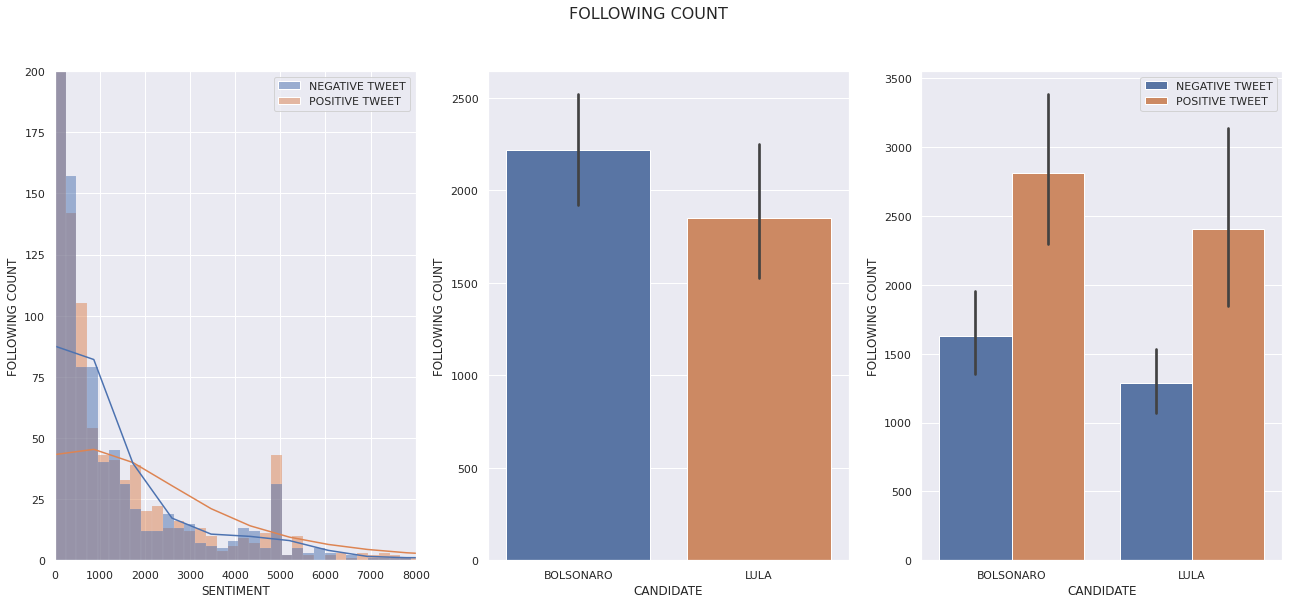

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (22,9))
sns.histplot(x = df.following_count,  hue= np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'), ax=ax[0], kde=True)
sns.barplot(x = df.subject,y = df.following_count, ax=ax[1])
# sns.barplot(x = np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),y = df.following_count,  hue= df.subject,ax=ax[2])
sns.barplot(x = df.subject ,y = df.following_count,  hue= np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),ax=ax[2])
ax[0].set_xlabel('SENTIMENT')
ax[0].set_ylim((0,200))
ax[0].set_xlim((0,8000))
ax[0].set_ylabel('FOLLOWING COUNT')
ax[1].set_ylabel('FOLLOWING COUNT')
ax[1].set_xlabel('CANDIDATE')
ax[1].set_xticks([0,1], ['BOLSONARO', 'LULA'])
ax[2].set_ylabel('FOLLOWING COUNT')
ax[2].set_xlabel('CANDIDATE')
ax[2].set_xticks([0,1], ['BOLSONARO', 'LULA'])
fig.suptitle('FOLLOWING COUNT', fontsize=16)
plt.legend()
plt.show()

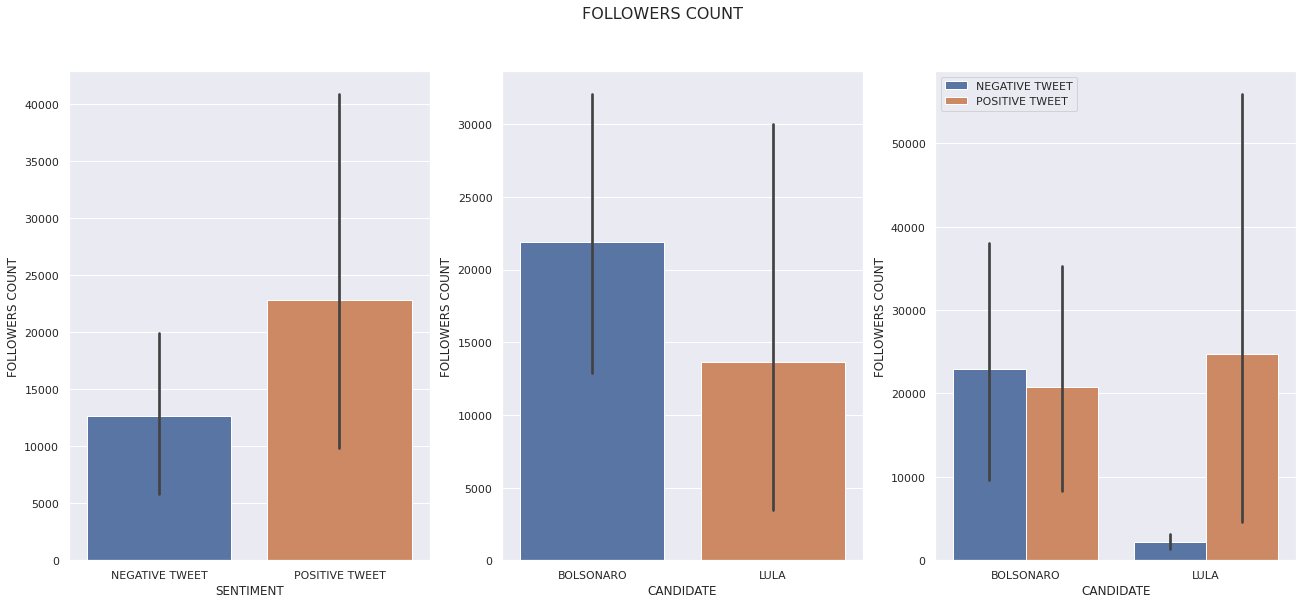

In [ ]:

fig, ax = plt.subplots(1,3, figsize = (22,9))
sns.barplot(x = np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),y = df.followers_count,  ax=ax[0])
sns.barplot(x = df.subject,y = df.followers_count, ax=ax[1])
# sns.barplot(x = np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),y = df.followers_count,  hue= df.subject,ax=ax[2])
sns.barplot(x = df.subject ,y = df.followers_count,  hue= np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),ax=ax[2])
ax[0].set_xlabel('SENTIMENT')
ax[0].set_ylabel('FOLLOWERS COUNT')
ax[1].set_ylabel('FOLLOWERS COUNT')
ax[1].set_xlabel('CANDIDATE')
ax[1].set_xticks([0,1], ['BOLSONARO', 'LULA'])
ax[2].set_ylabel('FOLLOWERS COUNT')
ax[2].set_xlabel('CANDIDATE')
ax[2].set_xticks([0,1], ['BOLSONARO', 'LULA'])
fig.suptitle('FOLLOWERS COUNT', fontsize=16)
plt.legend()
plt.show()

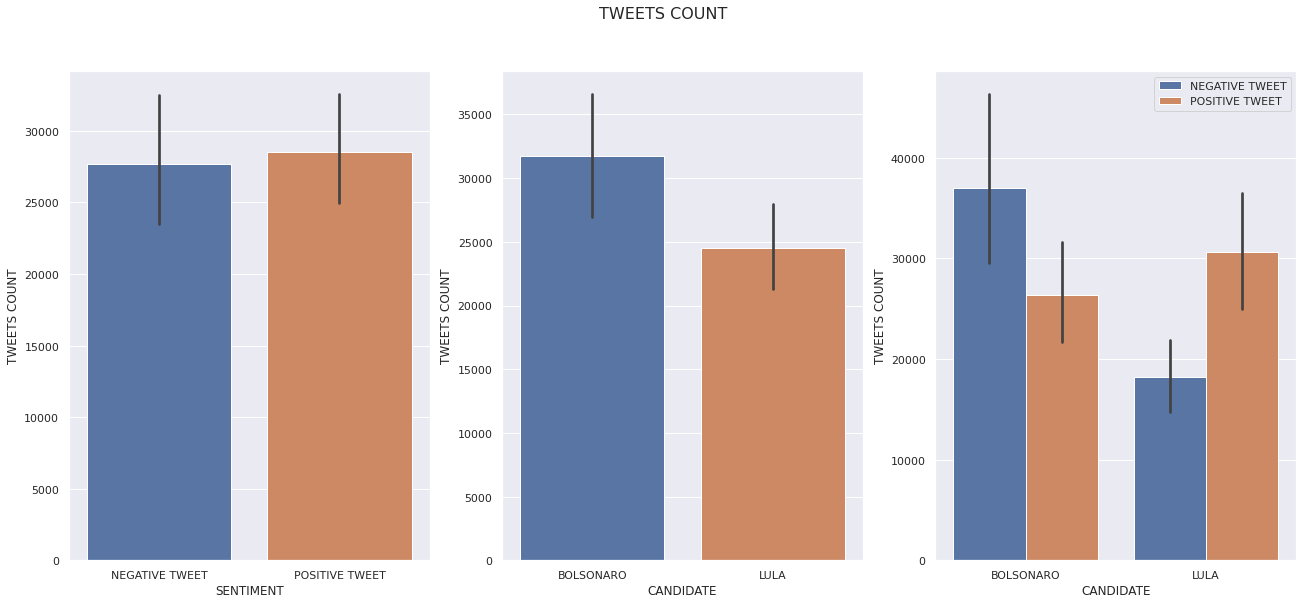

In [ ]:

fig, ax = plt.subplots(1,3, figsize = (22,9))
sns.barplot(x = np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),y = df.tweet_count,  ax=ax[0])
sns.barplot(x = df.subject,y = df.tweet_count, ax=ax[1])
# sns.barplot(x = np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),y = df.tweet_count,  hue= df.subject,ax=ax[2])
sns.barplot(x = df.subject ,y = df.tweet_count,  hue= np.where(df.target==1,'POSITIVE TWEET','NEGATIVE TWEET'),ax=ax[2])
ax[0].set_xlabel('SENTIMENT')
ax[0].set_ylabel('TWEETS COUNT')
ax[1].set_ylabel('TWEETS COUNT')
ax[1].set_xlabel('CANDIDATE')
ax[1].set_xticks([0,1], ['BOLSONARO', 'LULA'])
ax[2].set_ylabel('TWEETS COUNT')
ax[2].set_xlabel('CANDIDATE')
ax[2].set_xticks([0,1], ['BOLSONARO', 'LULA'])
fig.suptitle('TWEETS COUNT', fontsize=16)
plt.legend()
plt.show()

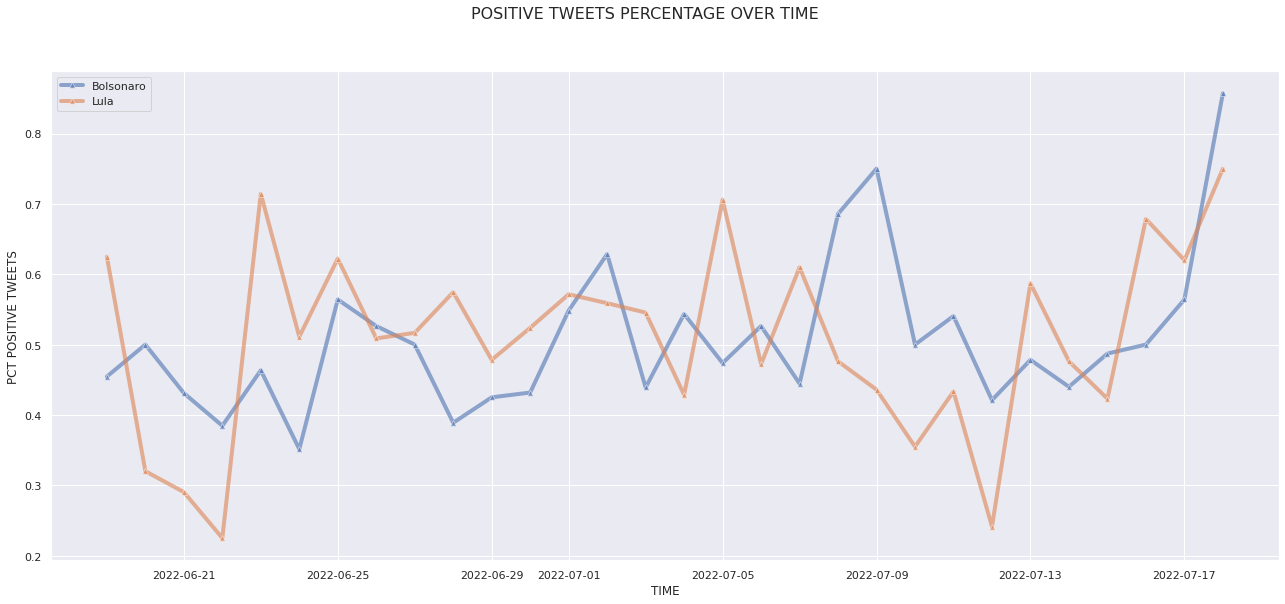

Correlation:  0.27583247561128094


In [ ]:
# Building time series dataframe
df_= df[['created_at','subject', 'target']].copy()
df_ = df_.rename(columns={'target':'positive_tweets', 'created_at':'date'})
df_['count'] = 1
df_ = df_.groupby(['date', 'subject'])[['positive_tweets', 'count']].sum()
df_['pct_positive_tweets'] = df_.positive_tweets / df_['count']
df_ = df_.reset_index()

df_lula = df_[df_.subject == 'lula']
df_bols = df_[df_.subject == 'bolsonaro']



fig, ax = plt.subplots(figsize = (22,9))
sns.lineplot(x = df_.date,y = df_bols.pct_positive_tweets,  ax=ax,  ci = None,  label = 'Bolsonaro', linewidth = 4, marker='^', alpha=0.6)
sns.lineplot(x = df_.date,y = df_lula.pct_positive_tweets,  ax=ax, ci = None, label = 'Lula', linewidth = 4, marker='^', alpha=0.6)

# sns.lineplot(x = df_.date,y = df_.positive_tweets,  ax=ax)
ax.set_xlabel('TIME')
ax.set_ylabel('PCT POSITIVE TWEETS')


fig.suptitle('POSITIVE TWEETS PERCENTAGE OVER TIME', fontsize=16)
plt.legend()
plt.show()

df_ = pd.concat([df_lula['pct_positive_tweets'].reset_index(drop=True), df_bols['pct_positive_tweets'].reset_index(drop=True)],  axis=1)
print('Correlation: ',df_.corr().iloc[1,0])

In [ ]:
flat_list = [item for sublist in df.tokens.tolist() for item in sublist]
print('Total number of words: ',len(flat_list))
print(f'Count "bolsonaro": {flat_list.count("bolsonaro")} or {100*flat_list.count("bolsonaro")/ len(flat_list):.{2}f} %')
print(f'Count "lula": {flat_list.count("lula")} or {100*flat_list.count("lula")/ len(flat_list):.{2}f} %')

Total number of words:  29991
Count "bolsonaro": 1283 or 4.28 %
Count "lula": 1429 or 4.76 %


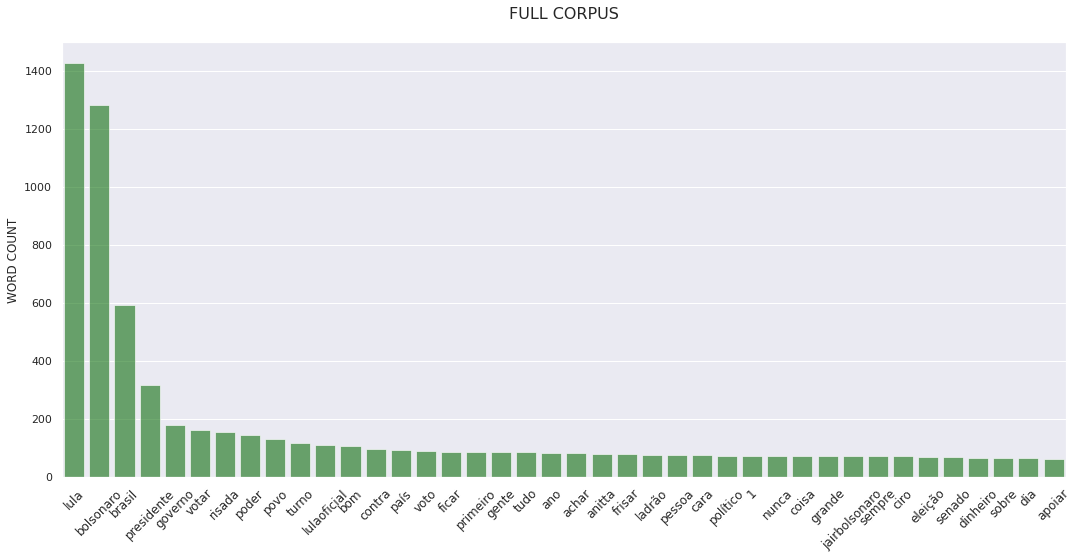

In [9]:
fig, ax = plt.subplots(figsize = (18,8))
# plt.subplots(constrained_layout=True)

df_fd_all = get_word_dist(df.tokens.tolist())
sns.barplot(x=df_fd_all[0], y=df_fd_all[1], ax=ax, color='green', alpha=0.6)


ax.set_xticklabels(df_fd_all[0], rotation=45, fontsize=12)
ax.set_title('FULL CORPUS\n', fontsize=16)
ax.set_xlabel('\n')
ax.set_ylabel('WORD COUNT')

plt.show()

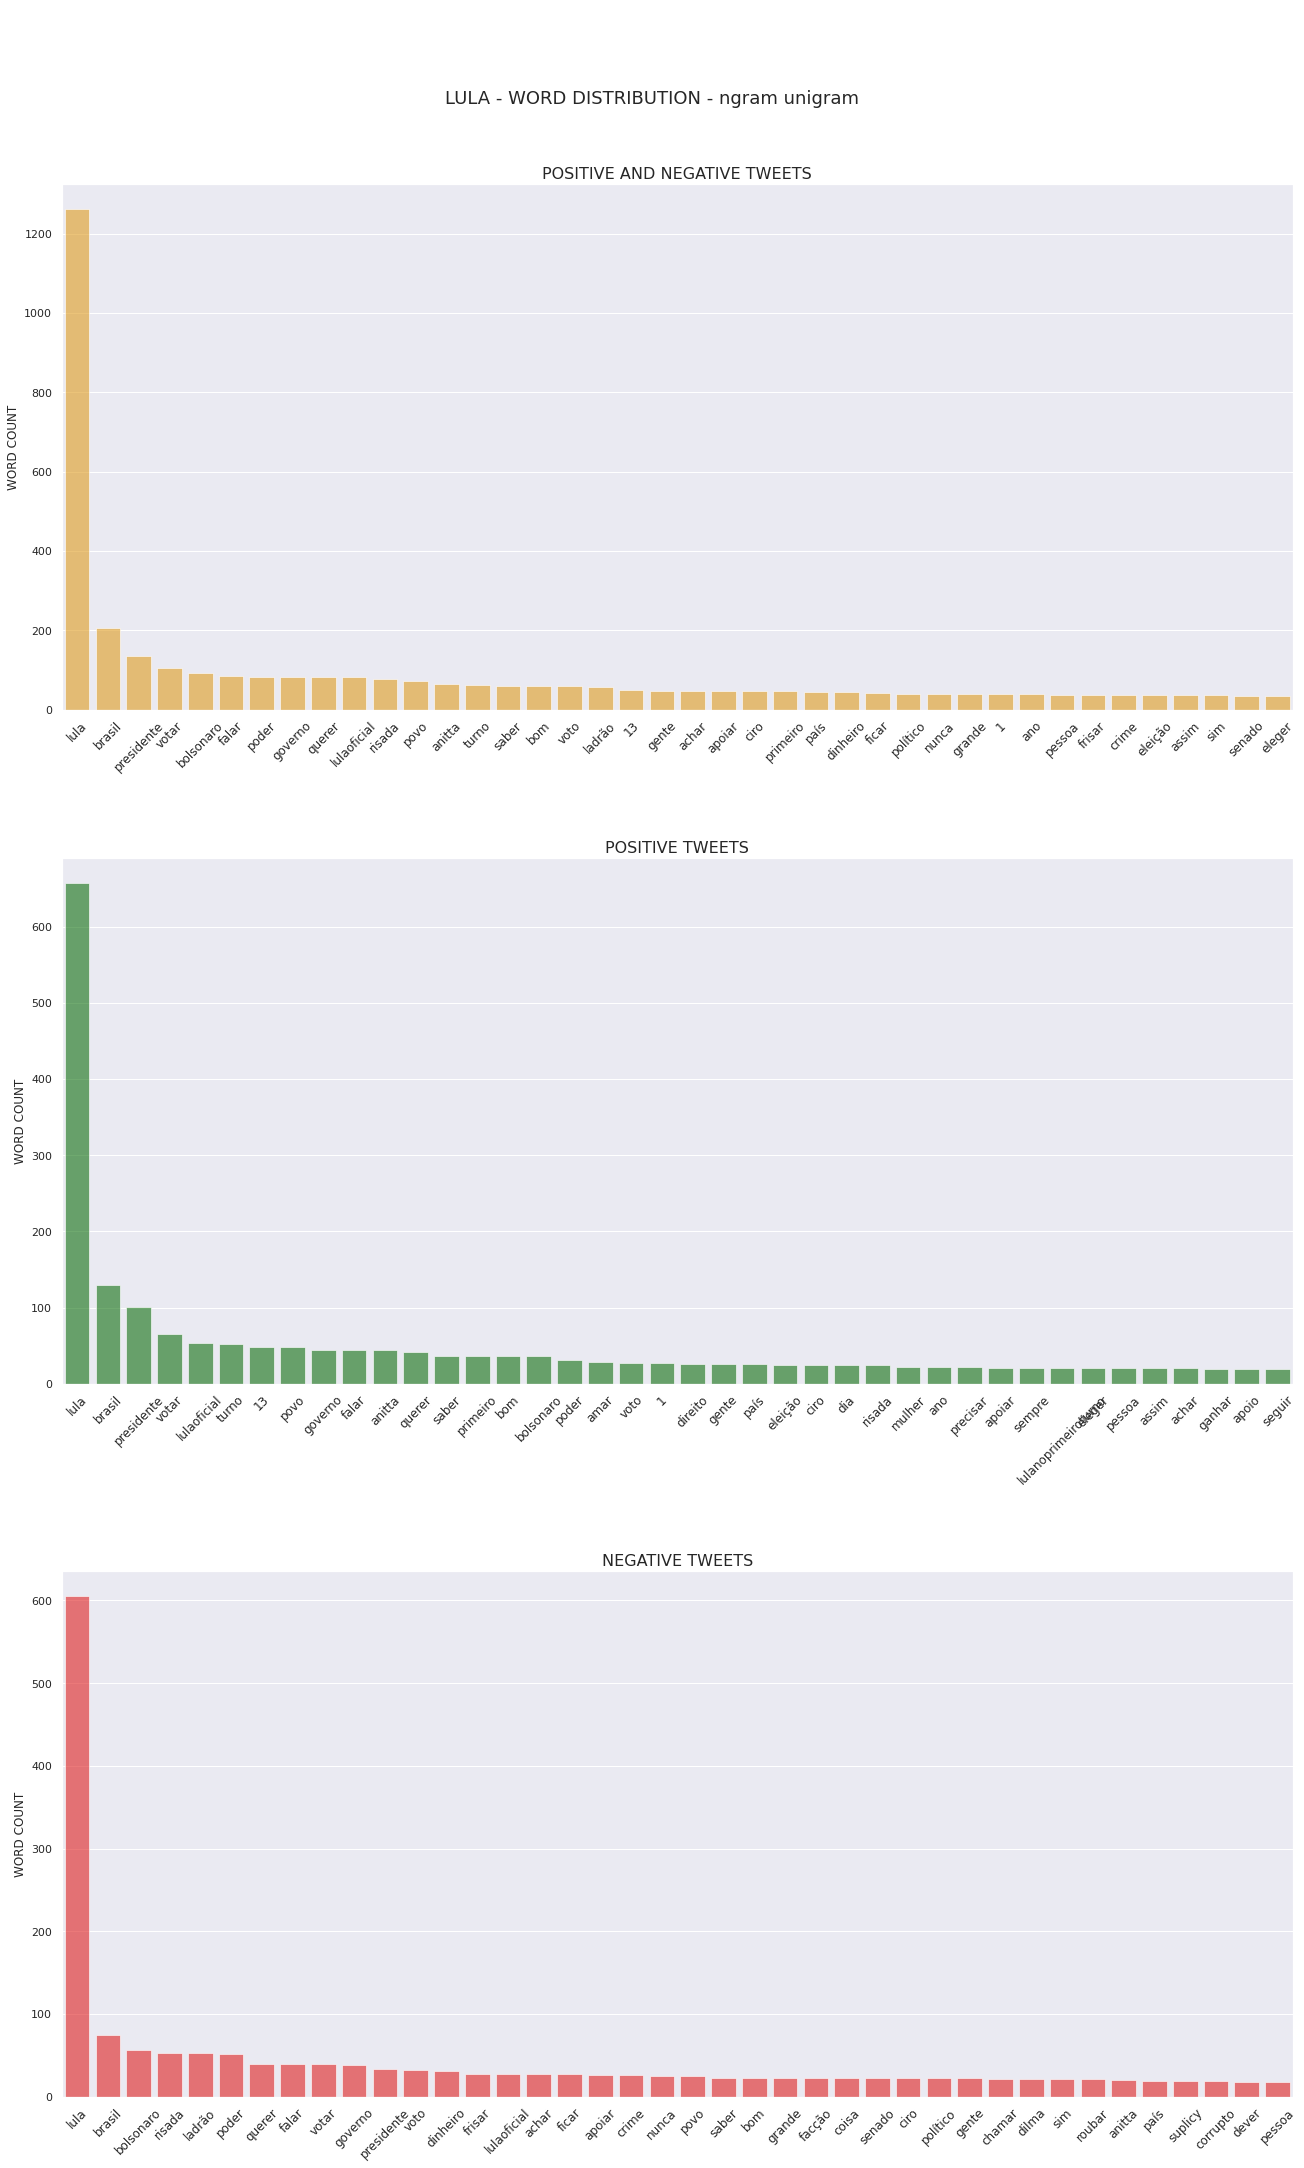

In [ ]:
plot_cadidate_wc('lula')

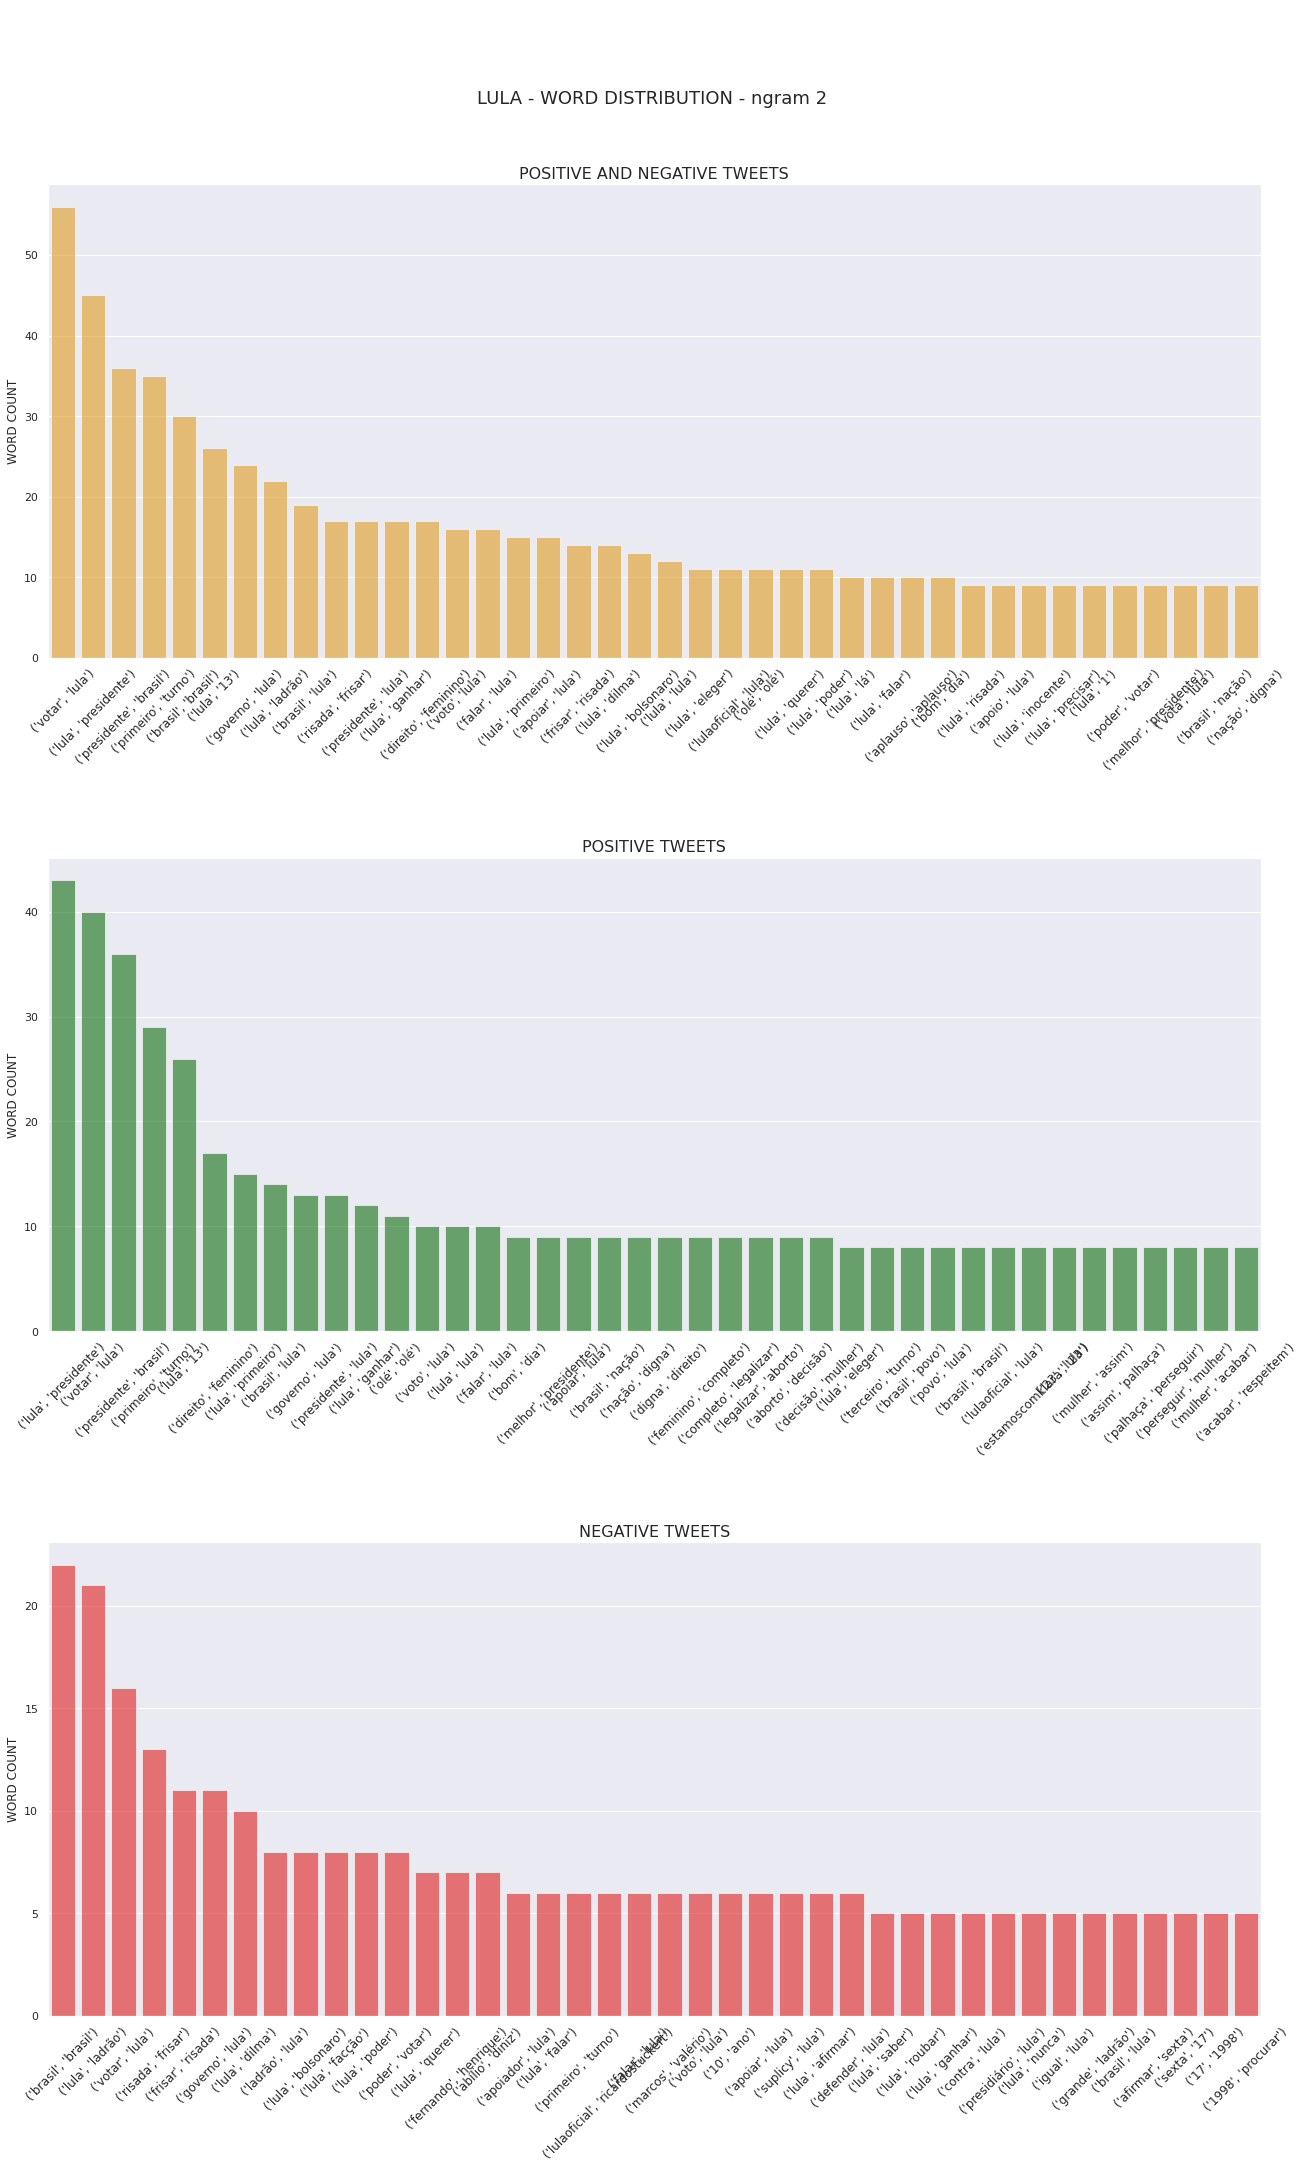

In [ ]:
plot_cadidate_wc('lula',2)

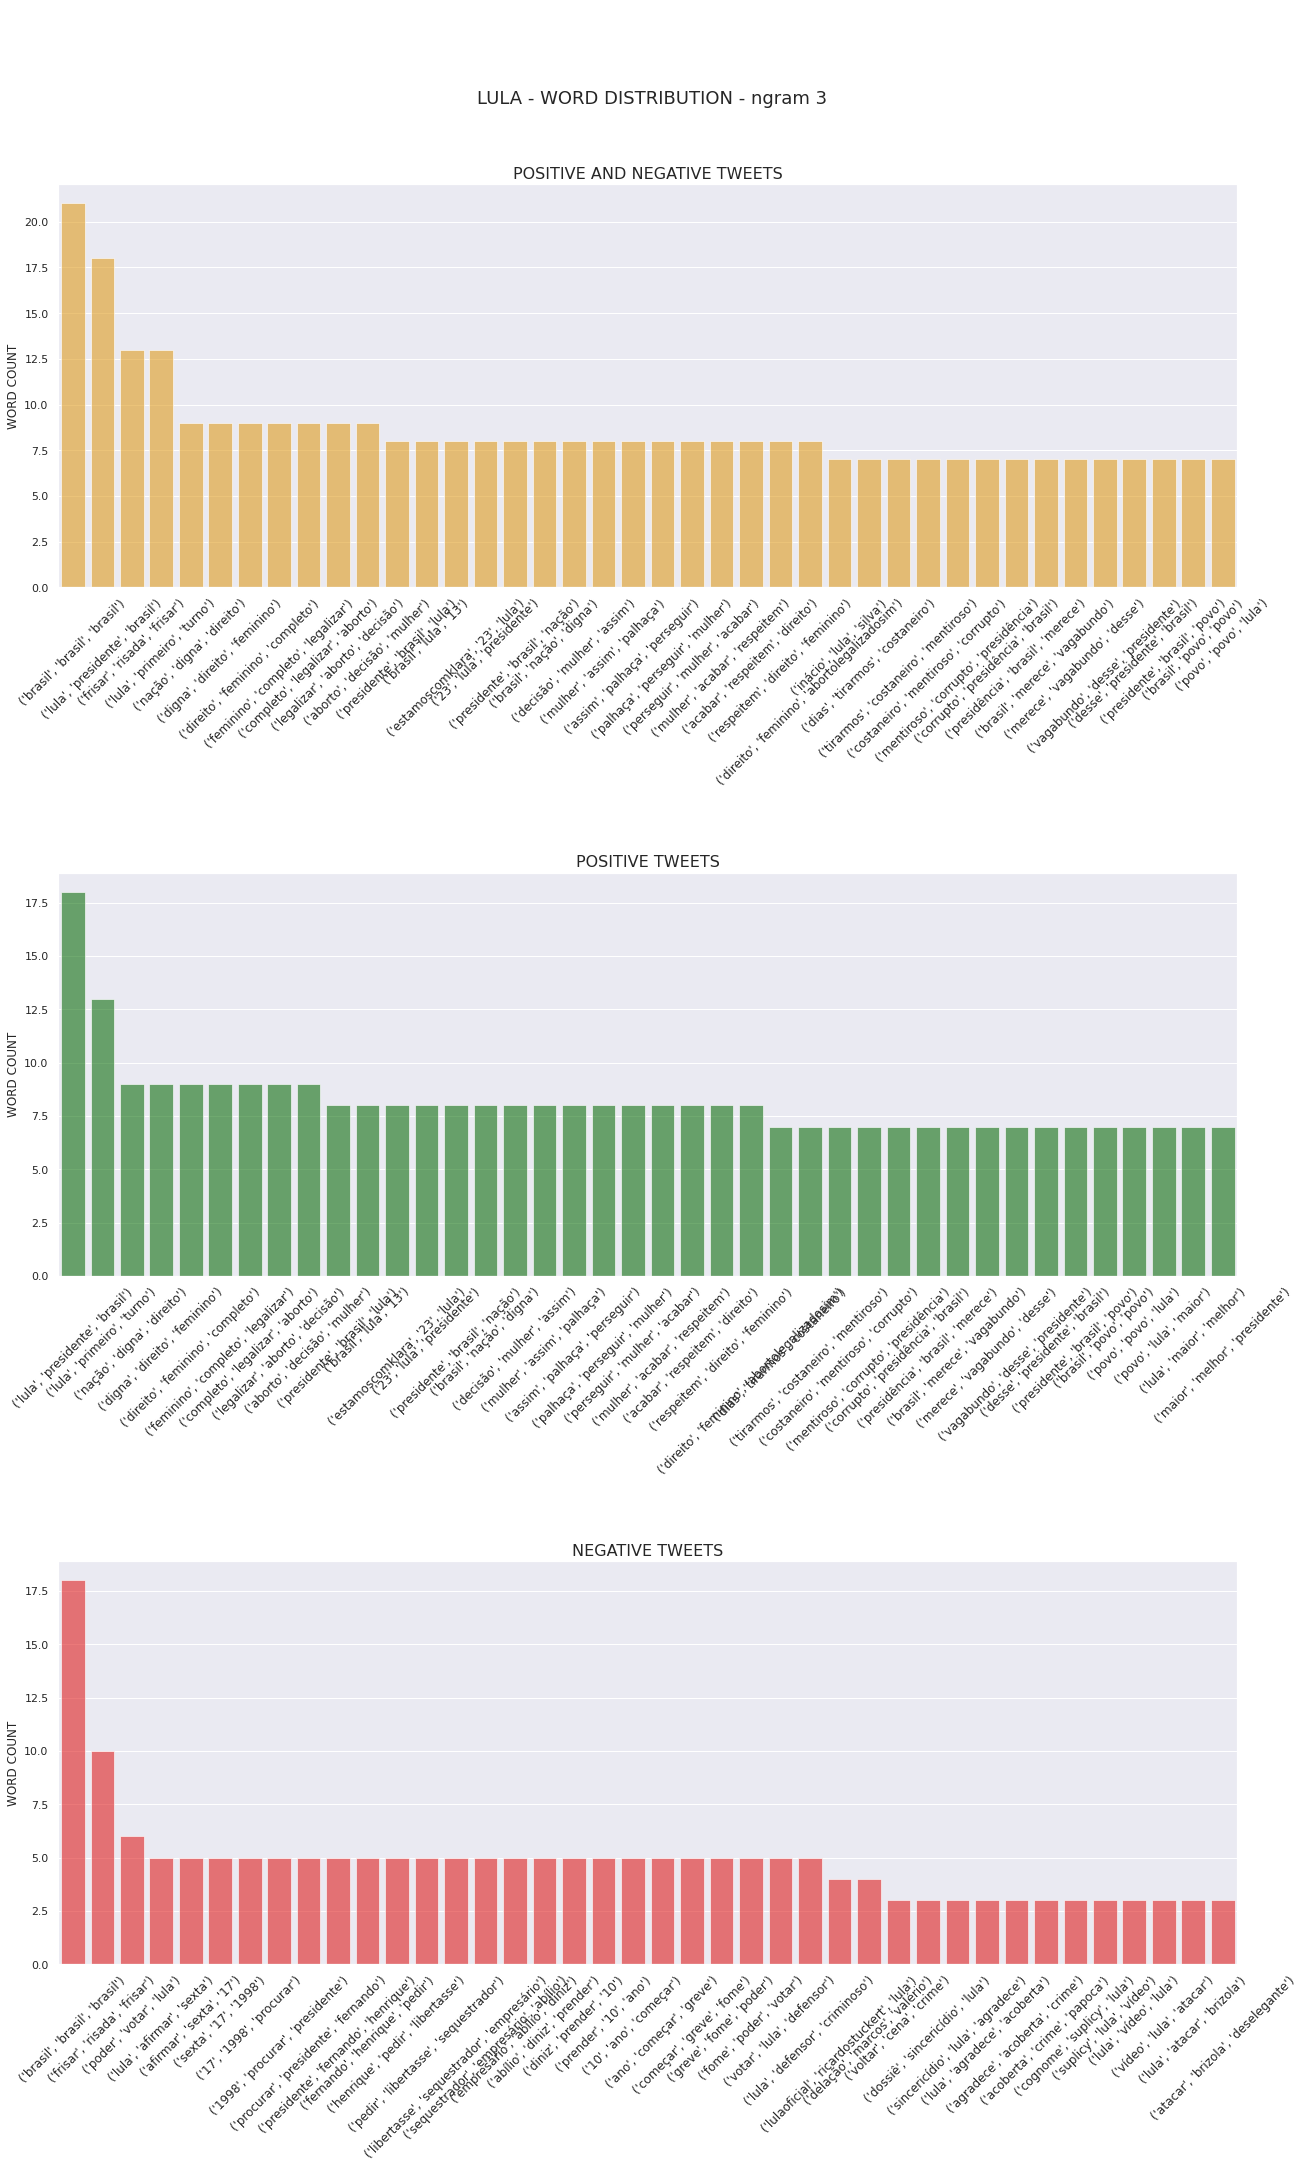

In [ ]:
plot_cadidate_wc('lula',3)

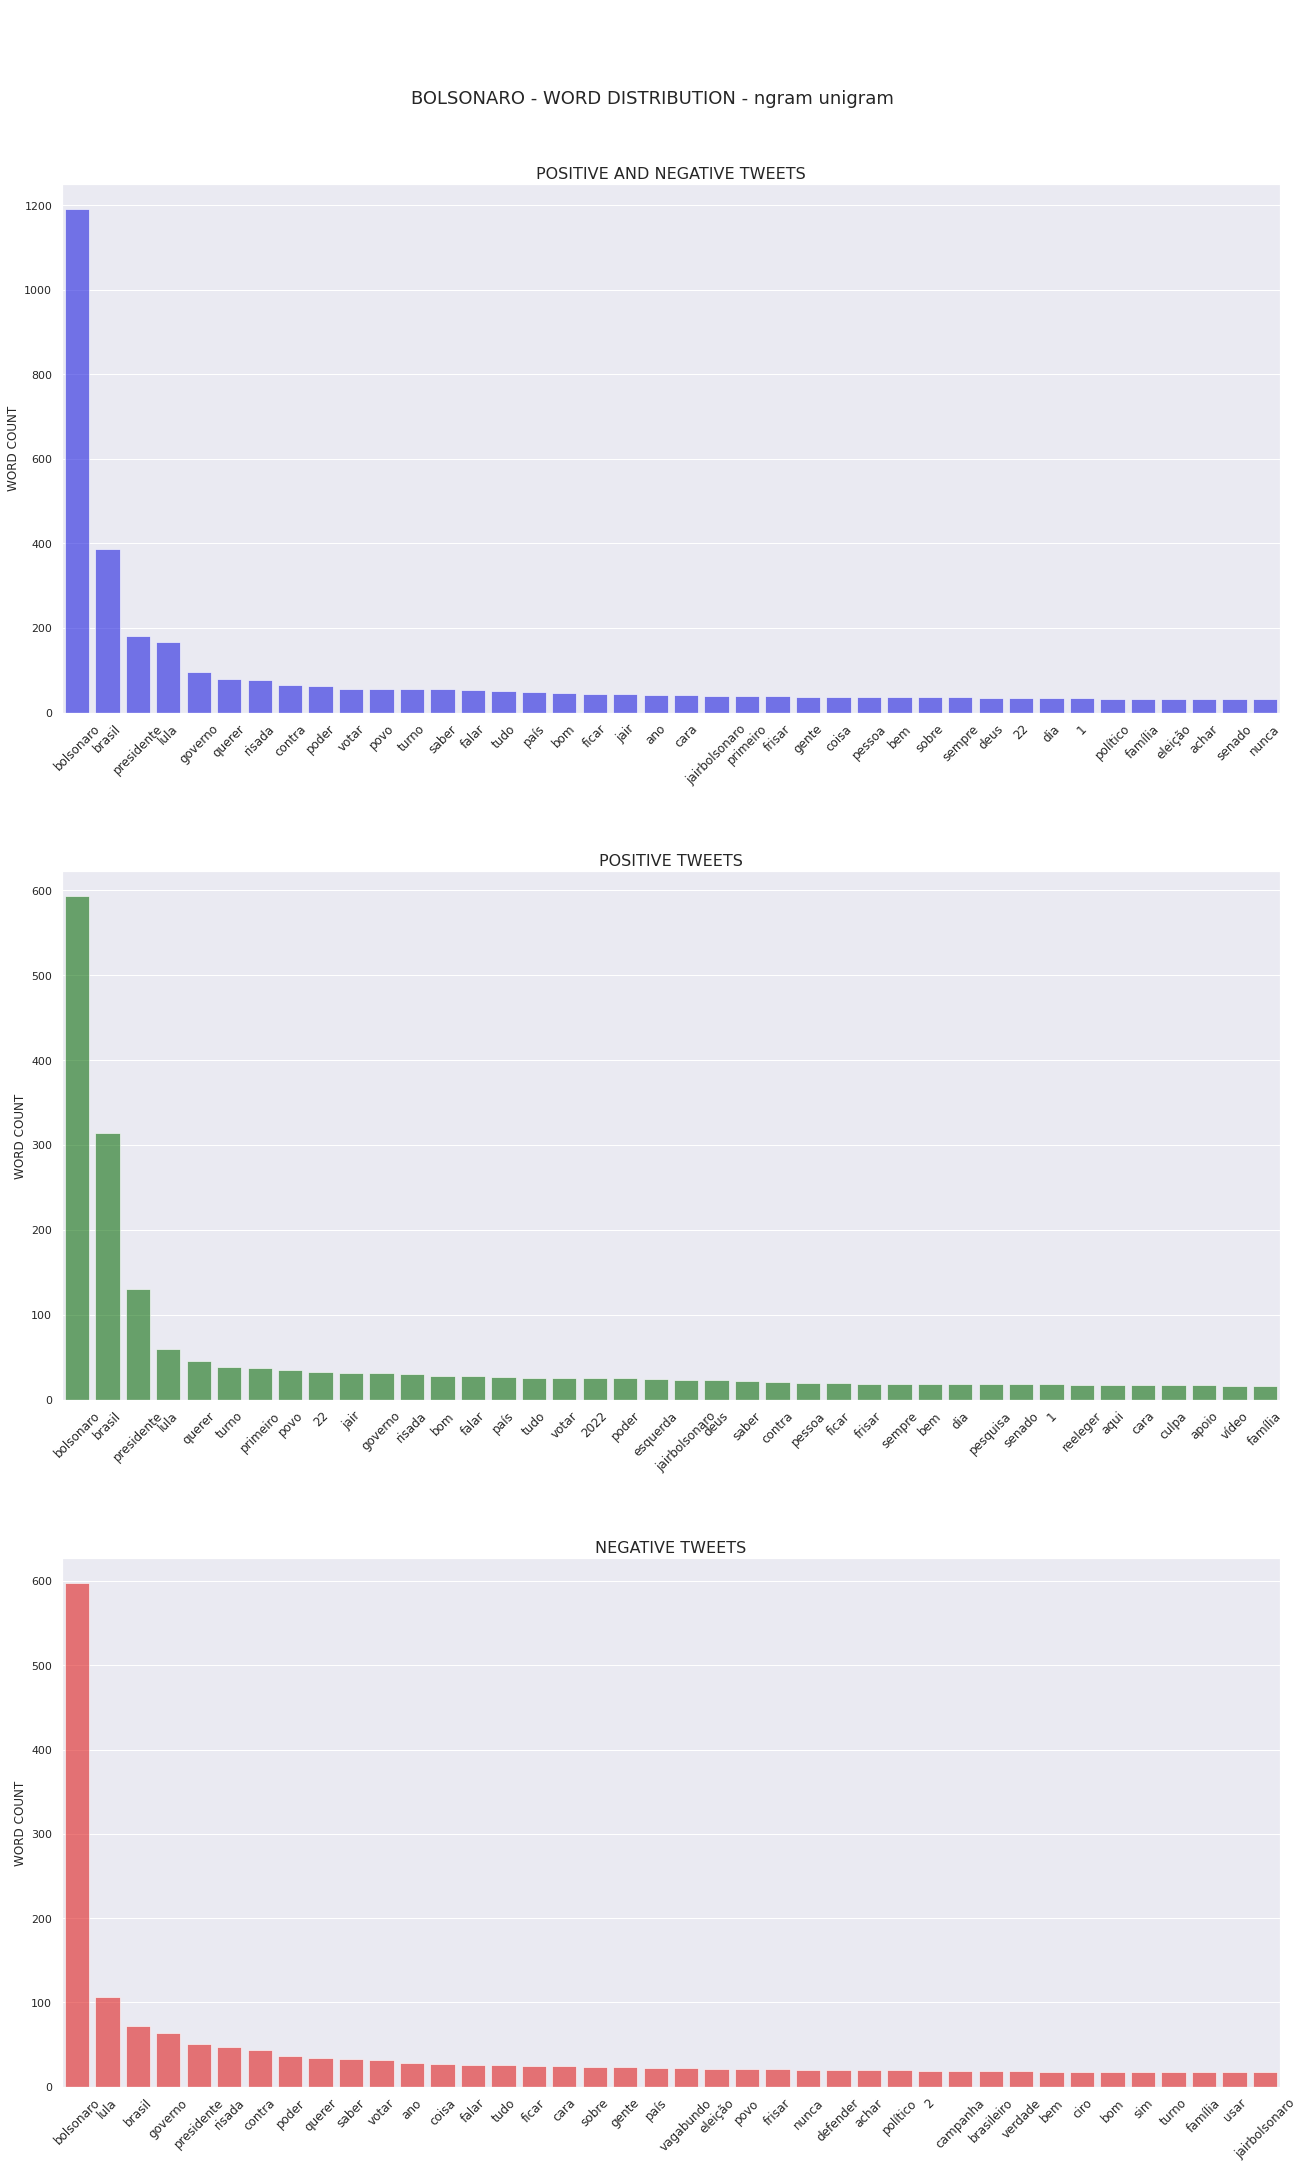

In [ ]:
plot_cadidate_wc('bolsonaro')

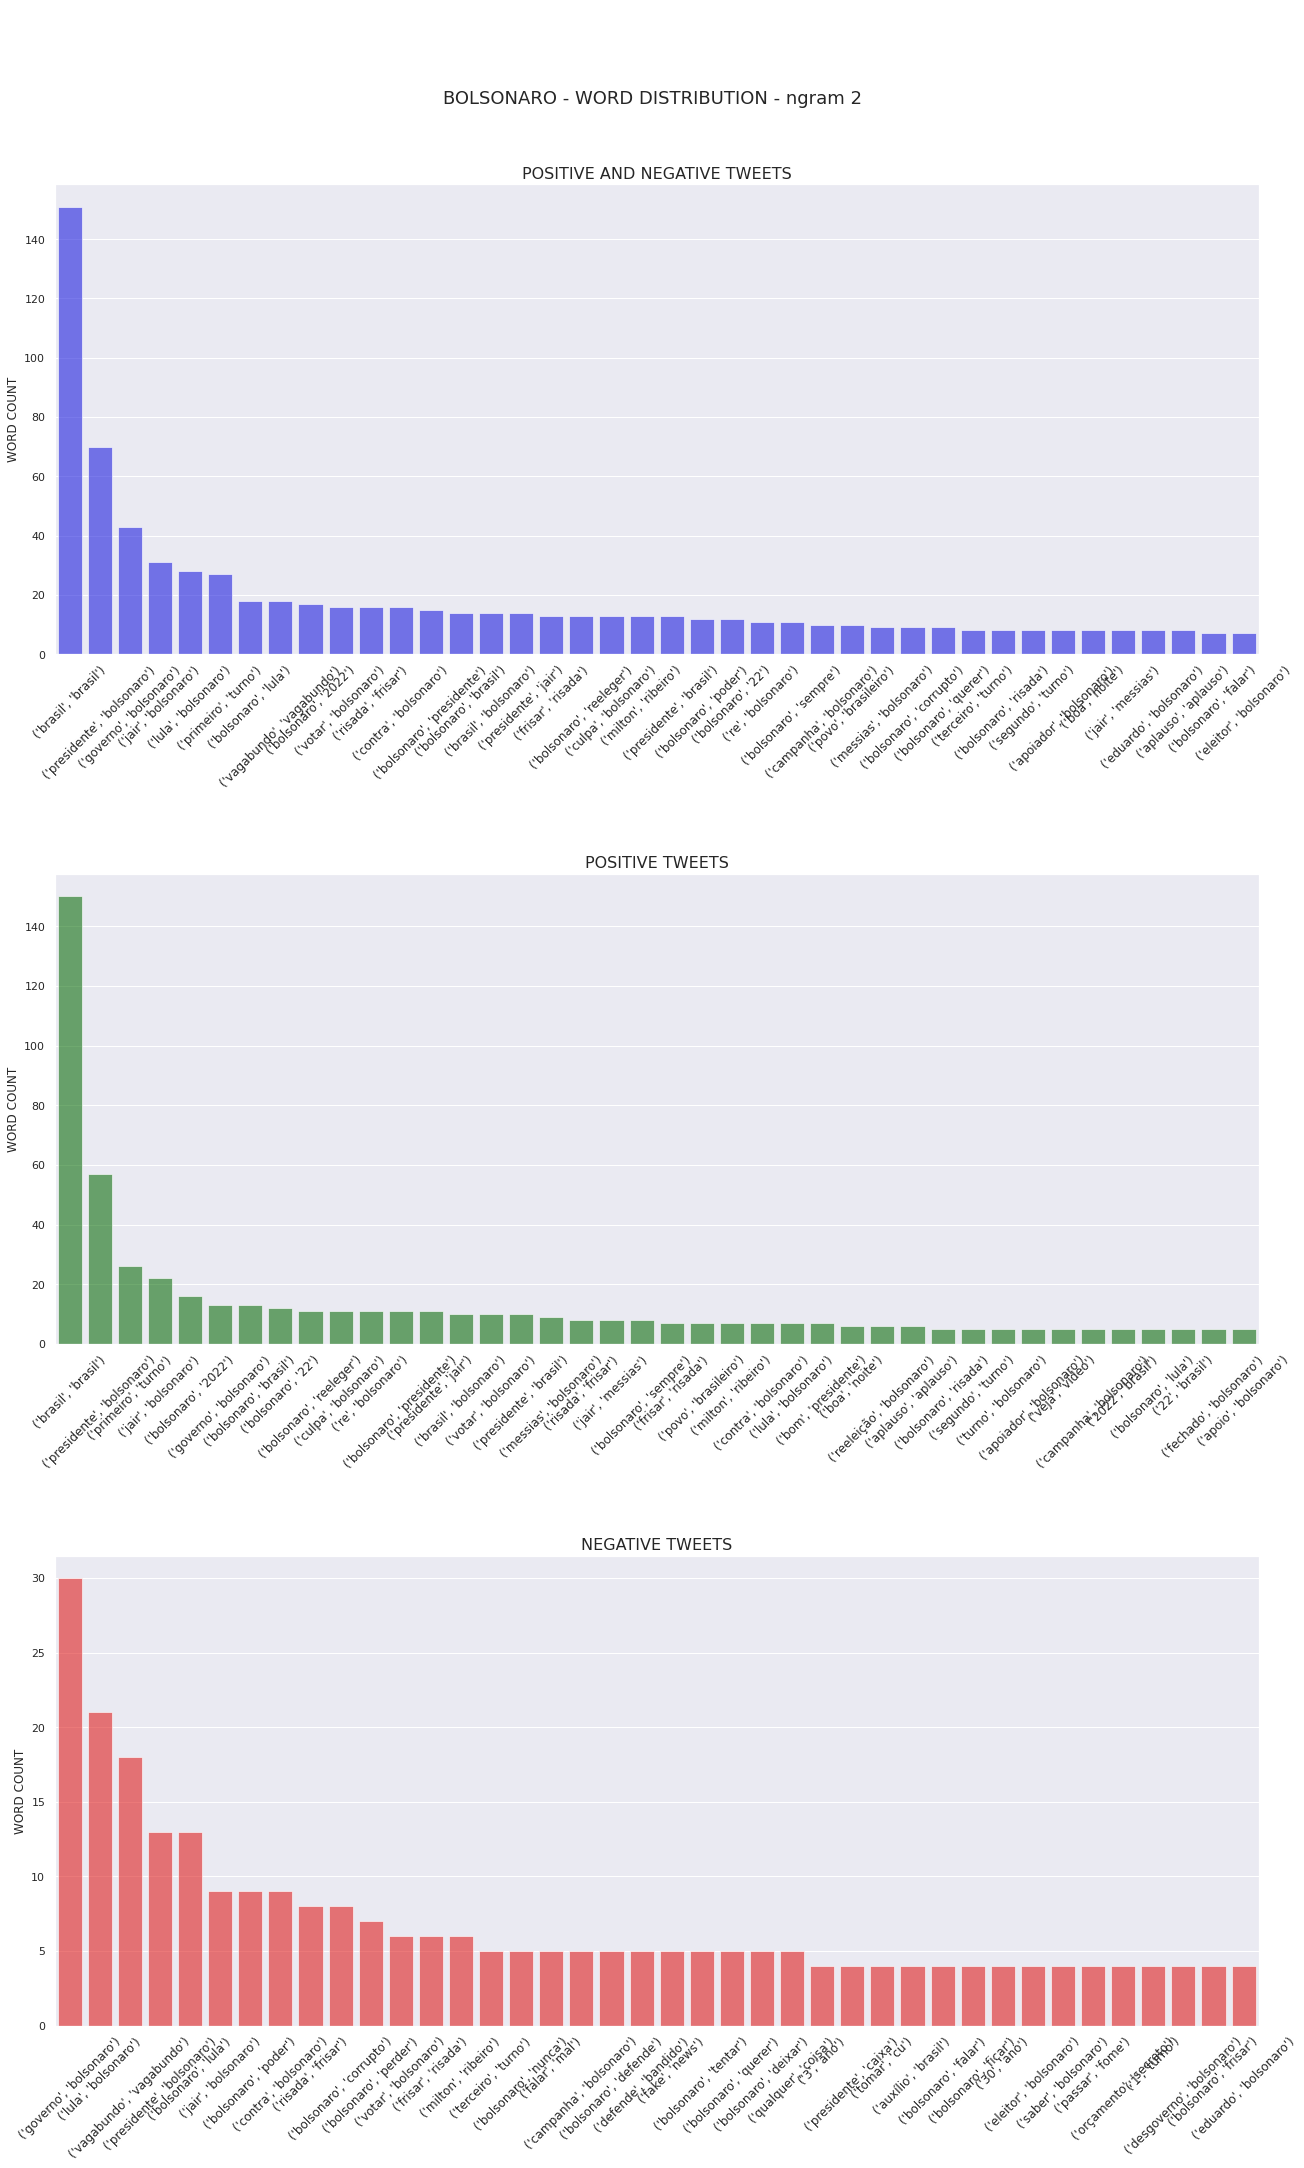

In [ ]:
plot_cadidate_wc('bolsonaro',2)

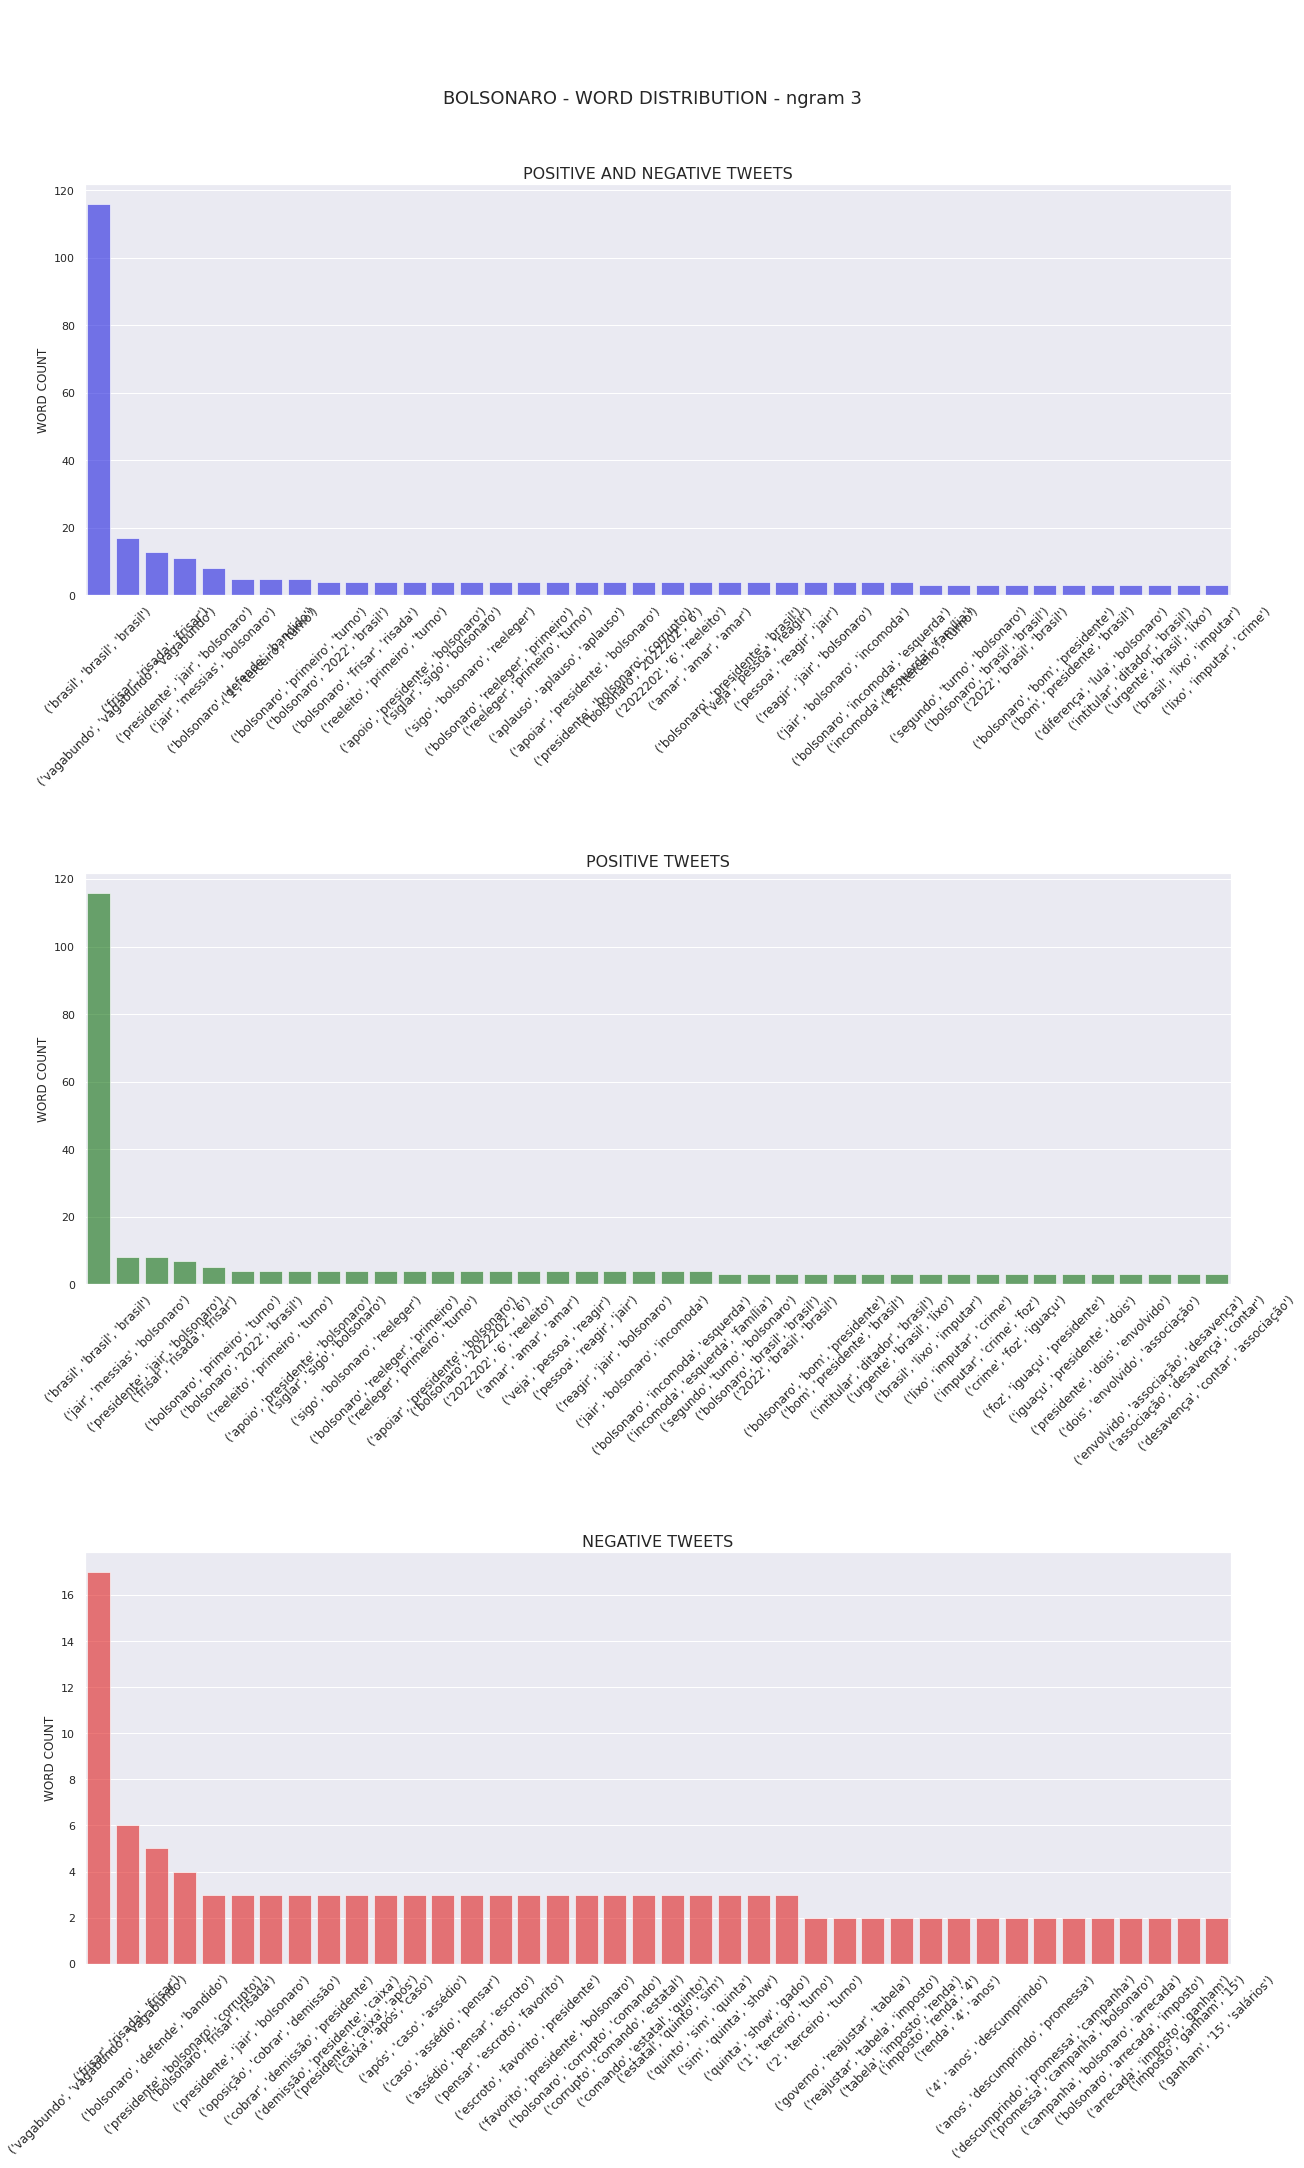

In [ ]:
plot_cadidate_wc('bolsonaro',3)

<br>

<br>

# Topic Modeling

Exploratory analysis through topic modeling techniques:

- K-means clustering
- Latent Dirichlet Allocation (LDA)



 ## K-means

In [ ]:
def tolist(corpus):
    return [list(i) for i in corpus]

# Load full corpus and split per candidate
full_corpus = pd.read_parquet('../../data/2-intermediate/tweets.parquet')
fc_lula = tolist(full_corpus[full_corpus.subject == 'lula'].tokens.tolist())
fc_bols = tolist(full_corpus[full_corpus.subject == 'bolsonaro'].tokens.tolist())
full_corpus = tolist(full_corpus.tokens.tolist())

# Split labeled corpus per candidate
labeled_corpus = tolist(df.tokens.tolist())
lc_lula = tolist(df[df.subject == 'lula'].tokens.tolist())
lc_bols = tolist(df[df.subject == 'bolsonaro'].tokens.tolist())



# Display corpus stats
corpus_dict = {
    'full_corpus' : full_corpus,
    'full_corpus_lula' : fc_lula,
    'full_corpus_bols' : fc_bols,
    'labeled_corpus' : labeled_corpus,
    'labeled_corpus_lula' : lc_lula,
    'labeled_corpus_bols' : lc_bols
}

for name, corpus in corpus_dict.items():
    print('\n',name.upper())
    print_corpus_stats(corpus)


 FULL_CORPUS
Number of docs: 18647
Words count: 243457
Average word length: 6.513281606197398

 FULL_CORPUS_LULA
Number of docs: 10041
Words count: 133685
Average word length: 6.344855443767065

 FULL_CORPUS_BOLS
Number of docs: 8606
Words count: 109772
Average word length: 6.718398134314762

 LABELED_CORPUS
Number of docs: 2271
Words count: 29991
Average word length: 6.530525824413991

 LABELED_CORPUS_LULA
Number of docs: 1136
Words count: 15423
Average word length: 6.378201387538092

 LABELED_CORPUS_BOLS
Number of docs: 1135
Words count: 14568
Average word length: 6.691790225151016


### Candidate Lula - TF-IDF

Best Silhouette score: 0.024833685948432983, Number of clusters: 23


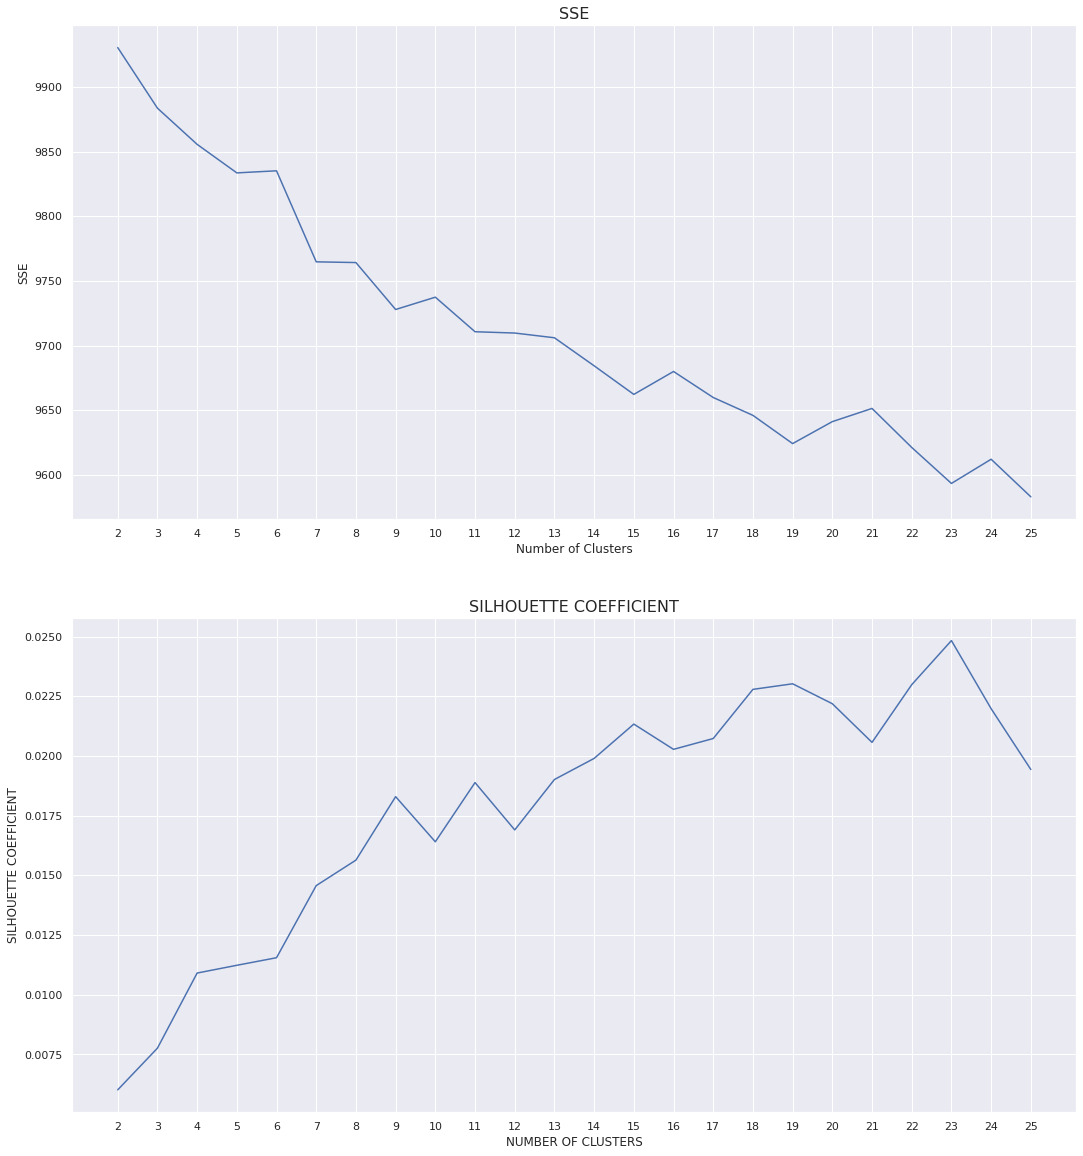

In [ ]:
corpus_train = fc_lula

corpus_predict = lc_lula
cls_target = [target for target in df[df.subject == 'lula'].target.tolist()]


tfidf = TfidfVectorizer(ngram_range=(1,3))
tfidf.fit([' '.join(tweet) for tweet in corpus_train])
vec_full = tfidf.transform([' '.join(tweet) for tweet in corpus_train])

eval_kmeans_clusters(25, vec_full)

cluster  number_of_docs  positive  negative  \
0        0               3         0         3   
1        1              92        50        42   
2        3              16        13         3   
3        4              22        16         6   
4        5               7         7         0   
5        6              11         6         5   
6        7             976       476       500   
7        8               9         9         0   

                                                                                                                                                                                                                                                                                                                                                                                                                   top_words  
0               sindicato metalúrgico desprezar - esperar sindicato - olhar suplicy - suplicy lula vídeo - lula atacar brizola - vídeo lula atacar - deselegante brizola ficar - esperar sindicato metalúrgico - deselegante - deselegante brizola - hora esperar - hora esperar sindicato - lula além voltar - dois hora esperar - dois hora - suplicy lula além - sindicato metalúrgico - brizola - suplicy lula - suplicy  
1                                                                                                                                                                                                                   ano ulular - bolsonaro - precisar - corrupção - programa - país - dilma - atual - lula governo - dinheiro - lulaoficial - bom - governar - brasil - ulular - ano - lula - sobre - governo lula - governo  
2      olha realidade - realidade lula primeiro - olha realidade lula - bolsonaro primeiro - bolsonaro primeiro turno - junto lula - guilhermeboulos lula - turno lula ladrão - nunca lula - primeiro turno vamosjuntospelobrasil - turno vamosjuntospelobrasil - guilhermeboulos lula primeiro - junto lula primeiro - nunca lula primeiro - lula - turno - primeiro turno - lula primeiro turno - primeiro - lula primeiro  
3                                                                                                                                            partido lava - jato prender - liderar pesquisa trocar - cargo super - lava - lava jato - votar - bbb - turno - lula ganhar asse - asse - ganhar asse - primeiro turno - lula - ganhar primeiro turno - primeiro - lula ganhar primeiro - ganhar primeiro - lula ganhar - ganhar  
4  maior melhor - presidência brasil merece - mentiroso corrupto presidência - brasil merece vagabundo - brasil merece - lula maior melhor - desse presidente brasil - povo lula maior - tirarmos costaneiro mentiroso - merece vagabundo - lula 13 lula - vagabundo desse - vagabundo desse presidente - brasil povo povo - lula presidente baixo - merece vagabundo desse - povo - presidente brasil - brasil - presidente  
5                                                                seguir esquerda nilsonhandebol - esquerda nilsonhandebol - sigo volta - seguir sigo volta - esquerda seguir - volta esquerda - seguir esquerda - esquerda seguir esquerda - sigo volta esquerda - volta esquerda seguir - votar - nilsonhandebol - sigo - lula seguir - seguir sigo - lula seguir sigo - votar lula seguir - votar lula - esquerda - seguir  
6                                                                                                                                                                                                                                   bom - povo - gente - lula presidente - achar - votar lula - voto - 13 - bolsonaro - querer - poder - lulaoficial - falar - ladrão - anitta - risada - votar - presidente - brasil - lula  
7                 completo legalizar - feminino completo - completo legalizar aborto - legalizar aborto - legalizar aborto decisão - digna direito - digna direito feminino - decisão mulher - direito feminino completo - estamoscomkla

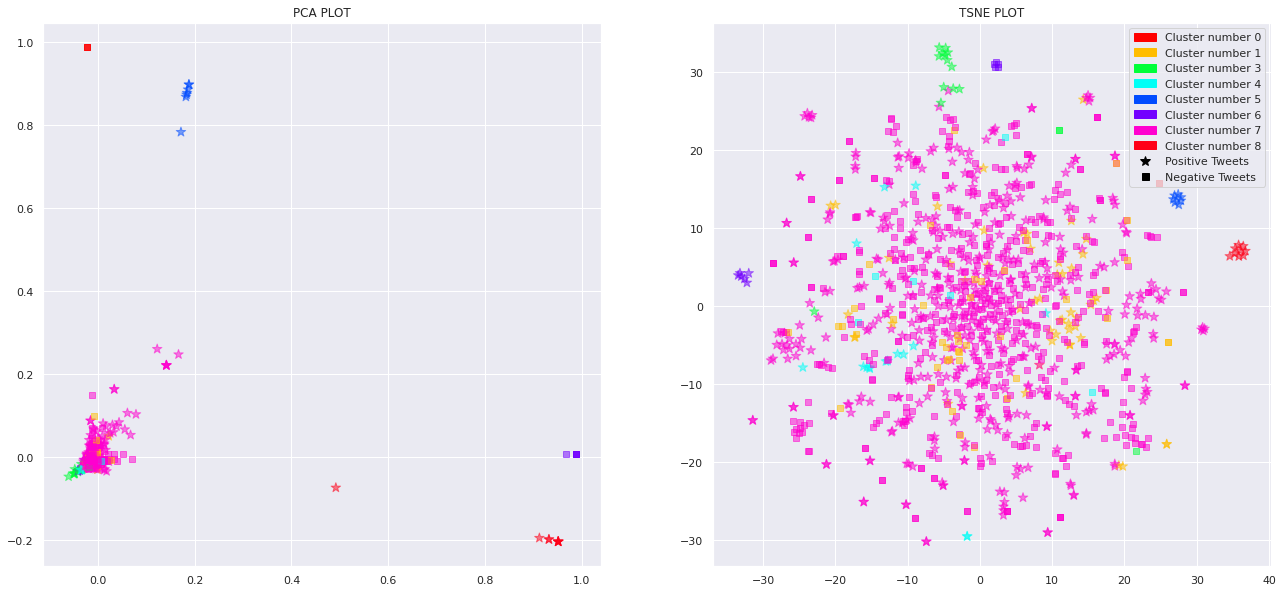

In [ ]:
# Vectorize and train clustering model with full data
means = KMeans(n_clusters=9).fit(vec_full)

# Predict labeled data
vec = tfidf.transform([' '.join(tweet) for tweet in corpus_predict])
labels = means.predict(vec)

# Evaluation
display(kmeans_summary(labels, get_top_keywords(vec, labels, tfidf.get_feature_names(), 20)))
plot_tsne_pca_full(vec, labels, cls_target)

### Candidate Bolsonaro - TF-IDF

Best Silhouette score: 0.01403269547180117, Number of clusters: 24


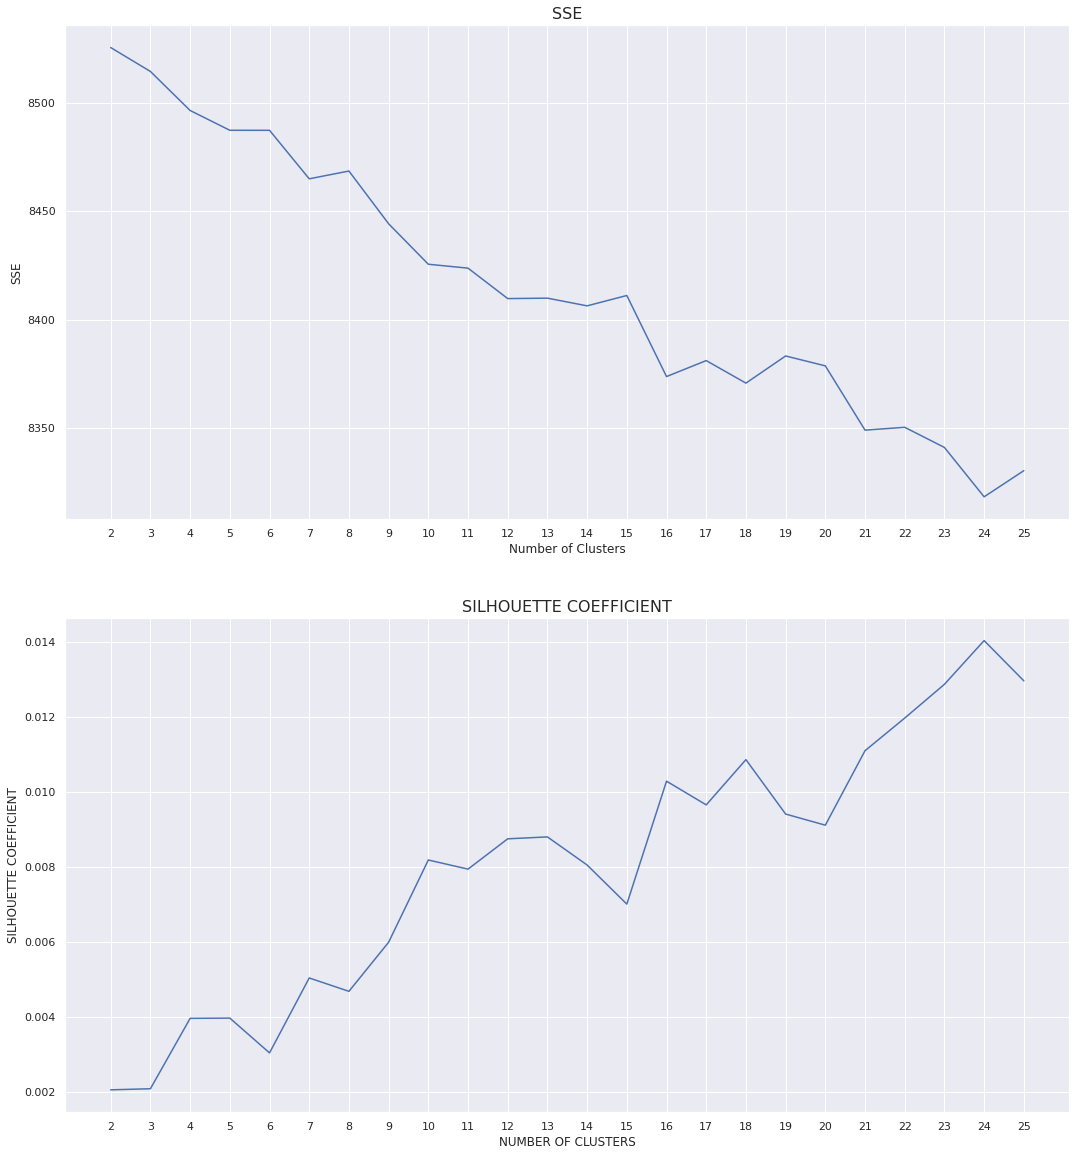

In [ ]:
corpus_train = fc_bols

corpus_predict = lc_bols
cls_target = [target for target in df[df.subject == 'bolsonaro'].target.tolist()]


tfidf = TfidfVectorizer(ngram_range=(1,3))
tfidf.fit([' '.join(tweet) for tweet in corpus_train])
vec_full = tfidf.transform([' '.join(tweet) for tweet in corpus_train])

eval_kmeans_clusters(25, vec_full)

cluster  number_of_docs  positive  negative  \
0        0             133        44        89   
1        1               3         3         0   
2        2              30        27         3   
3        3              58        18        40   
4        4              15        15         0   
5        5               2         1         1   
6        6              17         7        10   
7        7             875       445       430   
8        8               2         2         0   

                                                                                                                                                                                         top_words  
0                                                                                                turno - voto - querer - ibope - votar - ciro - bolsonaro lula - lula bolsonaro - bolsonaro - lula  
1                 lixo imputar crime - associação jornalismo lixo - imputar crime foz - imputar crime - brasil surreal - lixo brasil surreal - iguaçu presidente dois - lixo - brasil - associação  
2                            bolsonaro - bolsonaro reeleger primeiro - sigo bolsonaro - siglar - siglar sigo - sigo bolsonaro reeleger - siglar sigo bolsonaro - primeiro - primeiro turno - turno  
3                                                                 vergonha - político - poder - governo lula - político econômico - educação - corrupção - bolsonaro - governo bolsonaro - governo  
4                          re bolsonaro - bolsonaro 2022 brasil - bolsonaro brasil brasil - 2022 brasil brasil - amar amar amar - amar - amar amar - brasil - brasil brasil brasil - brasil brasil  
5  michele - michele bolsonaro - invejoso - brasil orgulhar michele - orgulhar michele bolsonaro - bolsonaro invejoso - michele bolsonaro invejoso - orgulhar michele - brasil orgulhar - orgulhar  
6                                          bolsonaro - pedir - risada risada - bolsonaro frisar risada - bolsonaro frisar - frisar risada - frisar risada frisar - risada frisar - risada - frisar  
7                                                                                           povo - tudo - contra - jair - risada - querer - presidente bolsonaro - presidente - brasil - bolsonaro  
8  escravidão poder escolha - escravidão poder - consequências - duas escolhas - duas escolhas bolsonaro - escolhas - bolsonaro 22 escravidão - escolhas bolsonaro - escolha consequências - baixo

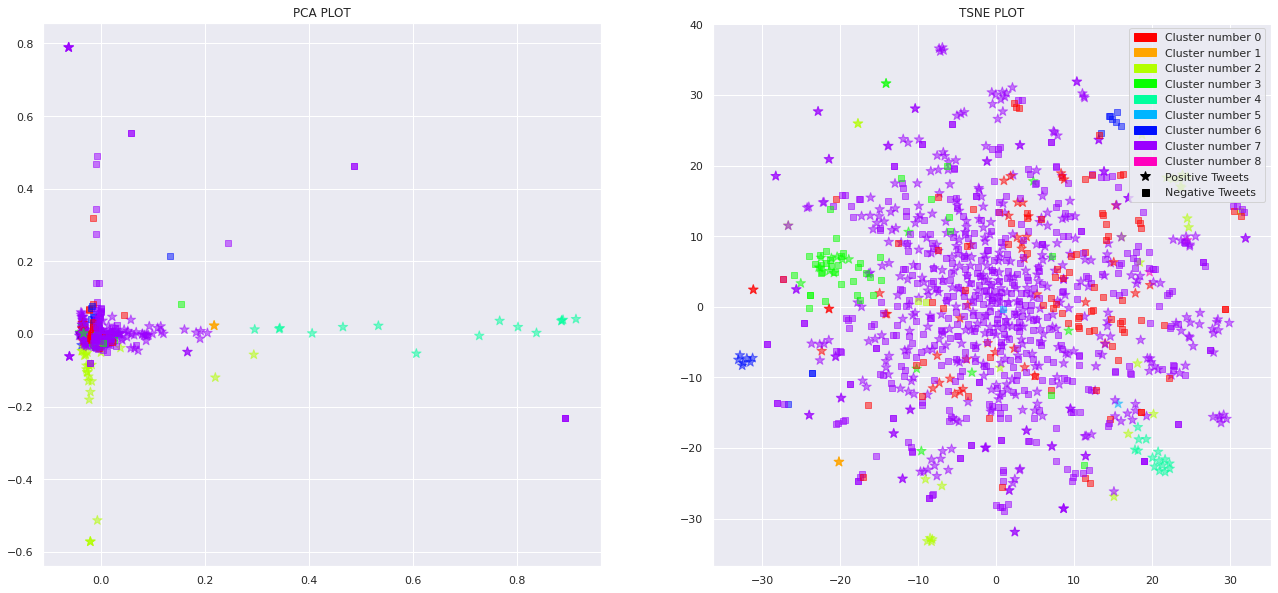

In [ ]:
# Vectorize and train clustering model with full data
means = KMeans(n_clusters=9).fit(vec_full)

# Predict labeled data
vec = tfidf.transform([' '.join(tweet) for tweet in corpus_predict])
labels = means.predict(vec)

# Evaluation
display(kmeans_summary(labels, get_top_keywords(vec, labels, tfidf.get_feature_names(), 10)))
plot_tsne_pca_full(vec, labels, cls_target)

## Train Word2Vec model

In [ ]:
model_original = KeyedVectors.load_word2vec_format("../../data/4-models/skip_s50.txt")

model = Word2Vec(size=50, min_count=1)
model.build_vocab(full_corpus)
model.intersect_word2vec_format("../../data/4-models/skip_s50.txt", lockf=1)
total_examples = model.corpus_count
model.train(corpus, total_examples=total_examples, epochs=100)

(1282661, 1456800)

### Candidate Lula

Best Silhouette score: 0.13046547770500183, Number of clusters: 2


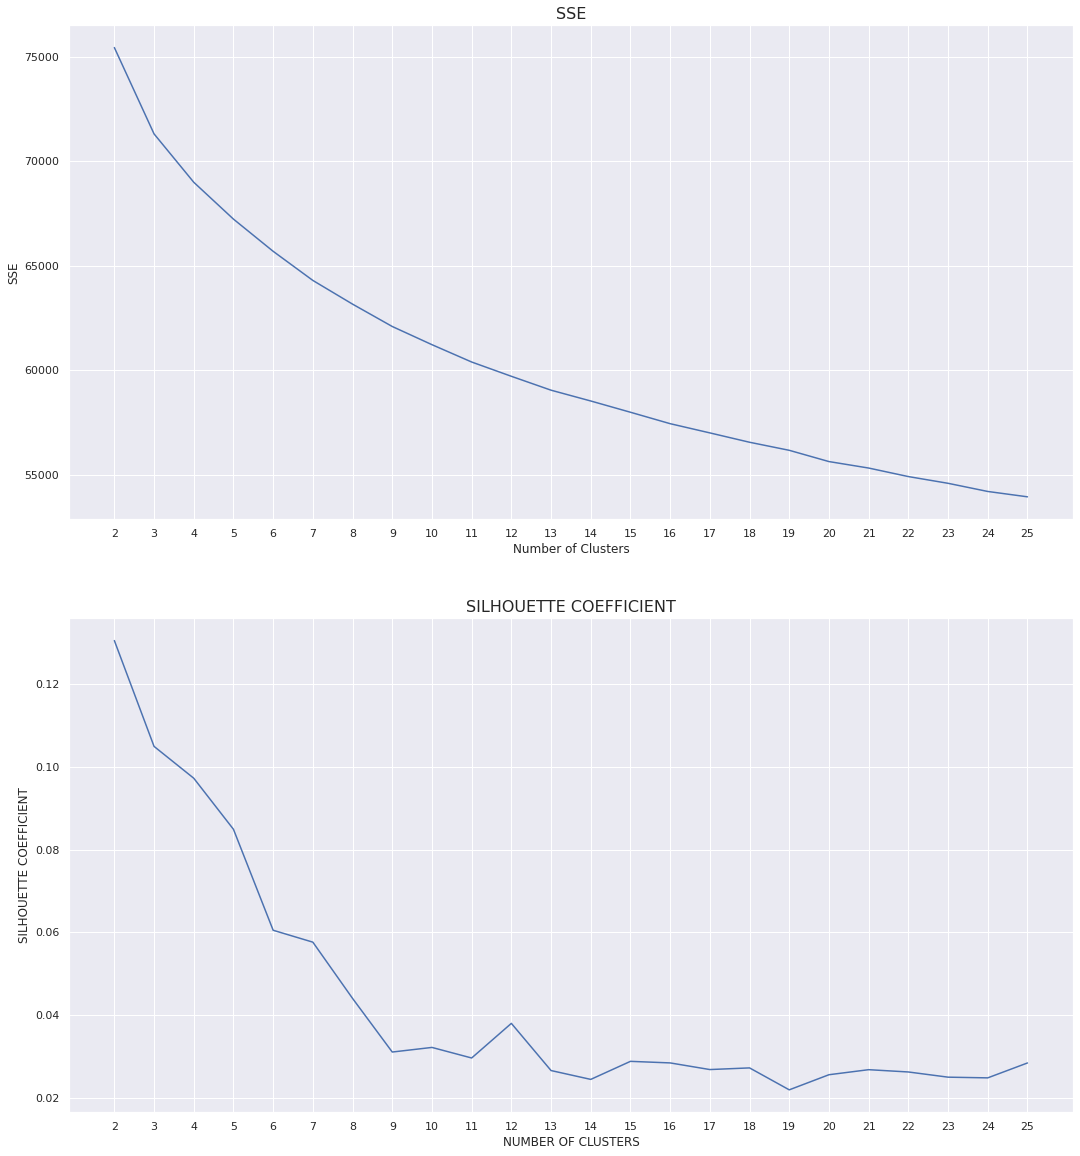

In [ ]:
corpus_train = fc_lula

corpus_predict = lc_lula
cls_target = [target for target in df[df.subject == 'lula'].target.tolist()]


vec_full = vectorize(corpus_train, model)
eval_kmeans_clusters(25, vec_full)

cluster  number_of_docs  positive  negative  \
0        0              60        21        39   
1        1             203       125        78   
2        2             297       145       152   
3        3              47        38         9   
4        4             529       248       281   

                                                                                                                                                                                                                top_words  
0                            [esculachar, picuinha, esculhambar, pergunto, porrada, pirar, dorzinha, desabafar, retrucar, entendo, assanhar, endoidar, cagada, risada, mentirinha, dizendo, chilique, aturar, acha, poxa]  
1                [lula, reelegê-lo, acovardar, acovardado, retrucar, decido, recado, desistirei, indignar, sabatinar, calhorda, desanimar, desabafar, arredar, opinar, querendo, desperdiçá-lo, garanto, desista, calhar]  
2                  [acha, garanto, acredito, sabendo, gabar, imaginando, calhar, pergunto, desperdiçá-lo, imagino, obviamente, creio, acredite, disto, desanimar, esculhambar, querendo, honestamente, entendo, endoidar]  
3                                  [turno, vitorioso, reelegê-lo, 2out2022, primeiro, 80, reeleito, 1, terceiro, folgada, tranquilo, indeciso, postulante, folga, perdedor, decido, esperançoso, reeleger, lula, vencido]  
4  [retrucar, desabafar, esculachar, endoidar, calhorda, esculhambar, dizendo, calhar, mentirada, acha, sabendo, garanto, recado, desperdiçá-lo, desanimar, obviamente, apequenar, euapoiobolsonaro2022, insinuar, gabar]

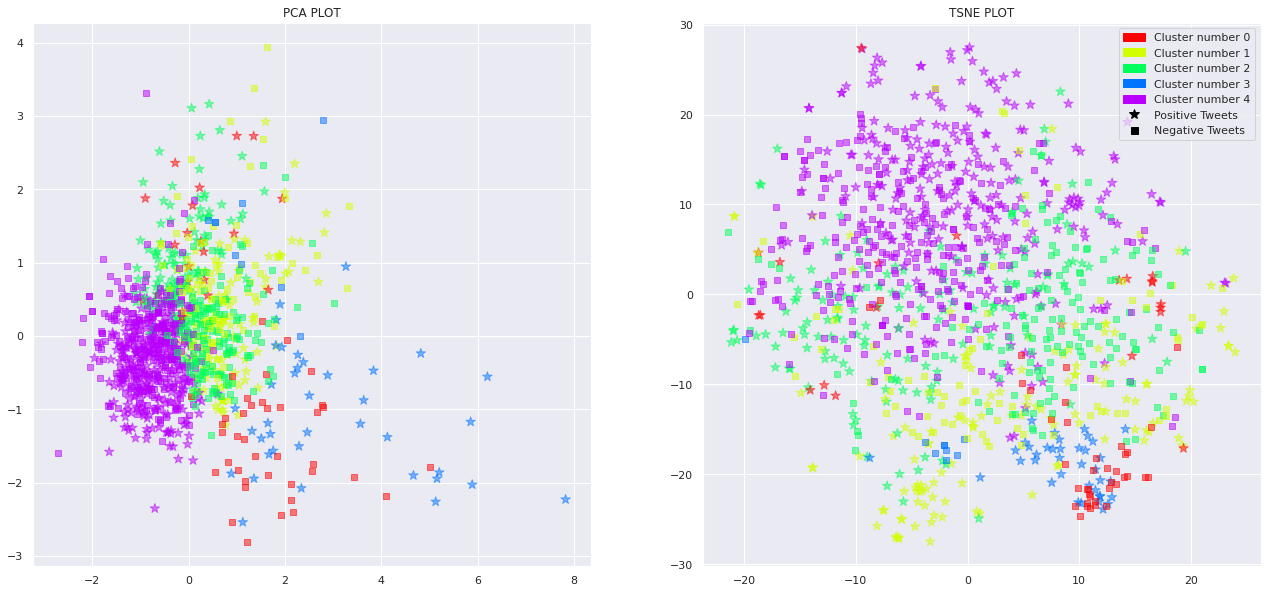

In [ ]:
n_clusters=5

# Vectorize and train clustering model with full data
means = KMeans(n_clusters=n_clusters).fit(vec_full)

# Pre-dict labeled data
vec = vectorize(corpus_predict, model)
labels = means.predict(vec)

# Evaluation
plot_tsne_pca_full_w2v(vec, labels, cls_target)
kmeans_summary(labels, get_top_keywords_w2v(n_clusters))

### Candidate Bolsonaro

Best Silhouette score: 0.19580445735013324, Number of clusters: 2


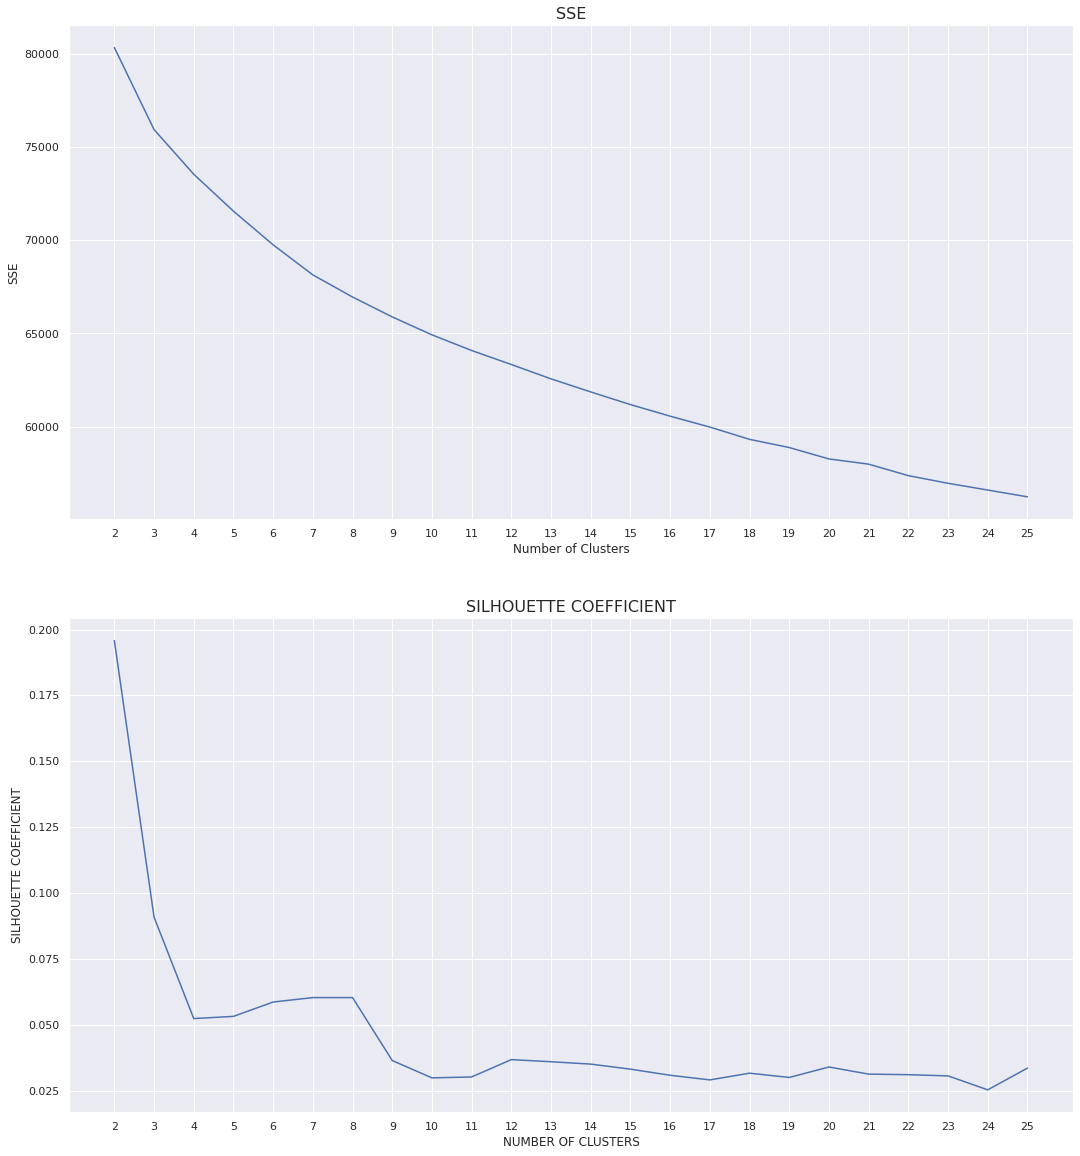

In [ ]:
corpus_train = fc_bols

corpus_predict = lc_bols
cls_target = [target for target in df[df.subject == 'bolsonaro'].target.tolist()]


vec_full = vectorize(corpus_train, model)
eval_kmeans_clusters(25, vec_full)

cluster  number_of_docs  positive  negative  \
0        0             205        93       112   
1        1             104        94        10   
2        2              85        54        31   
3        3             304       124       180   
4        4              68        33        35   
5        5             297       134       163   
6        6              72        30        42   

                                                                                                                                                                                                                                       top_words  
0  [constranger, indignar, reelegê-lo, insinuar, euapoiobolsonaro2022, acovardado, pessoalmente, decido, desabafar, valdenio2022, retrucar, farracomdinheiro, acovardar, dizendo, constrange, mentirada, recado, roubalheira, cassar, apequenar]  
1                                                                       [brasil, 22, contente, decido, garanto, honrado, acredito, gagá, coraçãozinho, nação, recado, a2226, doido, desisto, amado, alegrei, acovardado, ingrato, amar, desista]  
2                                                  [turno, reelegê-lo, vitorioso, reeleito, 2out2022, 80, decido, desistirei, perdedor, postulante, primeiro, desisto, recado, contentar, sabendo, reeleger, indeciso, esperançoso, folga, lula]  
3                                               [garanto, gabar, acredito, acha, imagino, sabendo, imaginando, creio, pergunto, acredite, decido, querendo, envergonhar, entendo, desperdiçá-lo, penso, honestamente, calhar, obviamente, disto]  
4                                   [bolsonaro, acovardado, acovardar, desabafar, retrucar, envergonhar, imagino, desisto, xingá-lo, esculhambar, covardia, lula, querendo, desistirei, constrangedor, doido, sacanear, decido, sarro, indignar]  
5                                                  [desabafar, gabar, percebi, retrucar, esculhambar, dizendo, recado, garanto, esculachar, sabendo, endoidar, acredito, decido, imaginando, acha, mentirada, doido, disto, obviamente, imagino]  
6                                                  [desabafar, esculachar, poxa, porrada, pergunto, pirar, dorzinha, risada, esculhambar, retrucar, entendo, sarro, picuinha, cagada, cansadinho, assanhar, dizendo, percebo, incomodo, chateia]

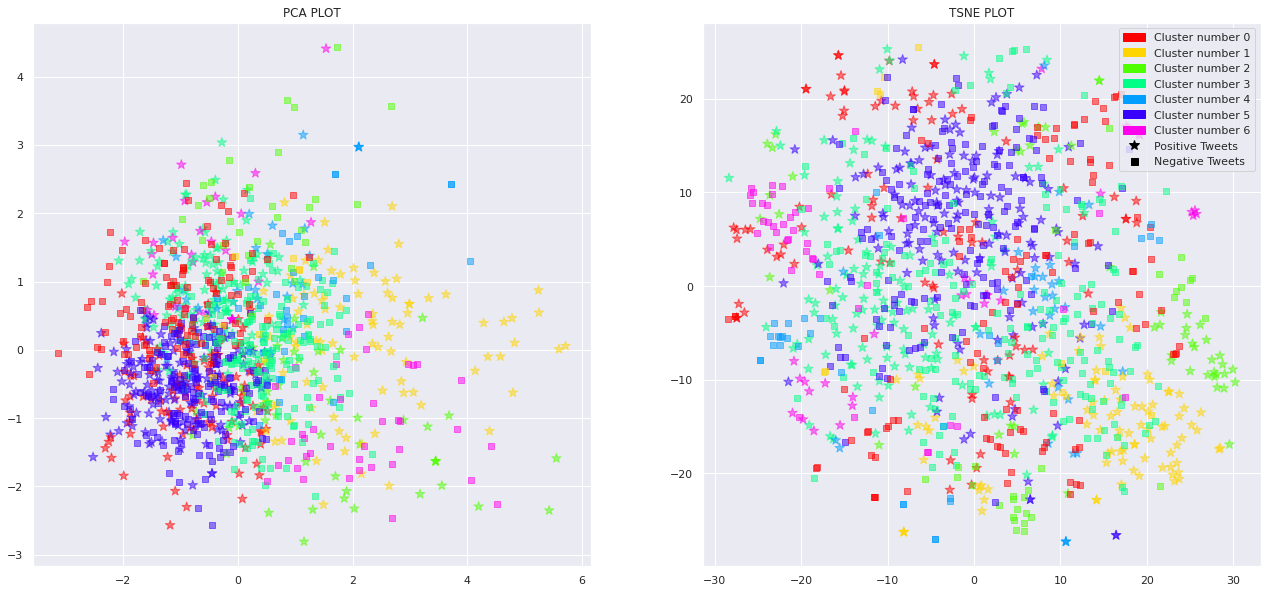

In [ ]:
n_clusters=7

# Vectorize and train clustering model with full data
means = KMeans(n_clusters=n_clusters).fit(vec_full)

# Pre-dict labeled data
vec = vectorize(corpus_predict, model)
labels = means.predict(vec)

# Evaluation
plot_tsne_pca_full_w2v(vec, labels, cls_target)
kmeans_summary(labels, get_top_keywords_w2v(n_clusters))

## LDA

### Candidate Lula

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim import models
import pyLDAvis.gensim
import pyLDAvis


dictionary = corpora.Dictionary(fc_lula)
corpus = [dictionary.doc2bow(tweet) for tweet in fc_lula]

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=4)


pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
LDAvis_prepared


/home/andre/Documents/scripts/fedbytweets-ml/.venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/andre/Documents/scripts/fedbytweets-ml/.venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/andre/Documents/scripts/fedbytweets-ml/.venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/andre/Documents/scripts/fedbytweets-ml/.venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  fro

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.003644  0.013390       1        1  34.912755
2     -0.008077  0.045754       2        1  25.420301
1     -0.047490 -0.034117       3        1  20.586974
0      0.051923 -0.025027       4        1  19.079970, topic_info=           Term          Freq         Total Category  logprob  loglift
25       brasil   1467.000000   1467.000000  Default  30.0000  30.0000
4          lula  10014.000000  10014.000000  Default  29.0000  29.0000
3        ladrão    407.000000    407.000000  Default  28.0000  28.0000
59   presidente   1052.000000   1052.000000  Default  27.0000  27.0000
590        povo    553.000000    553.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
154       nunca     65.376512    301.117137   Topic4  -5.9834   0.1292
111       votar     74.387169    857.608725   Topic4  -5.8543  -0.7883
42       senado     64.274244    278.853568   Topic4  -6.0004   0.1890
25       brasil     72.140286   1467.292542   Topic4  -5.8850  -1.3560
59   presidente     67.019742   1052.315069   Topic4  -5.9586  -1.0972

[353 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
1782       1  0.162228       
1782       2  0.811139       
10         1  0.478465      1
10         2  0.185212      1
10         3  0.169778      1
...      ...       ...    ...
90         1  0.224638  vídeo
90         2  0.306822  vídeo
90         3  0.093142  vídeo
90         4  0.378049  vídeo
10636      1  0.792243    yes

[740 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

# Candidate Bolsonaro

In [ ]:
dictionary = corpora.Dictionary(fc_bols)
corpus = [dictionary.doc2bow(tweet) for tweet in fc_bols]

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=4)


pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.001170 -0.018678       1        1  29.757292
0     -0.047502  0.028528       2        1  29.004981
1      0.000656 -0.038137       3        1  24.129072
2      0.048017  0.028287       4        1  17.108655, topic_info=        Term         Freq        Total Category  logprob  loglift
2     brasil  2136.000000  2136.000000  Default  30.0000  30.0000
110     lula  1248.000000  1248.000000  Default  29.0000  29.0000
47     poder   509.000000   509.000000  Default  28.0000  28.0000
10       ver   655.000000   655.000000  Default  27.0000  27.0000
5    governo   663.000000   663.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
71     turno    51.994094   321.446127   Topic4  -5.9067  -0.0561
369    sobre    45.243733   259.822668   Topic4  -6.0457   0.0177
780  eleição    45.342860   272.514041   Topic4  -6.0435  -0.0279
55     falar    50.646015   512.233329   Topic4  -5.9329  -0.5483
389      dar    44.421296   364.151043   Topic4  -6.0641  -0.3383

[369 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
418       1  0.169701        
418       3  0.763655        
4961      1  0.090636       0
4961      2  0.664665       0
4961      3  0.151060       0
...     ...       ...     ...
5310      2  0.694618  vídeos
473       1  0.602496   único
473       2  0.184636   único
473       3  0.145765   único
473       4  0.068024   único

[740 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])